# Przetwarzanie danych

In [1]:
from sklearn.preprocessing import StandardScaler
from skfuzzy.cluster import cmeans
from sklearn.metrics import pairwise_distances_argmin_min
from sktime.datasets import load_basic_motions, load_arrow_head
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff

### Parametry startowe programu

In [2]:
chunk_length = 100
n_clusters = 4
dim = 6
injection = 0.7
m = 2
g_error = 0.05

### Dane

In [3]:
%cd ..

C:\Users\kubak\Desktop\Klasyfikator


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
# load an example time series panel in numpy mtype Numpy 2D
X_train, y_train = load_basic_motions(split="train", return_type="numpy2D")
X_test, y_test =  load_basic_motions(split="test", return_type="numpy2D")

In [5]:
# load an example time series panel in numpy mtype Numpy 3D
X_train, y_train = load_basic_motions(split="train", return_type="numpy3D")
X_test, y_test =  load_basic_motions(split="test", return_type="numpy3D")

In [6]:
from libraries.load import load_dataset_to_dataframe

filepath_train = './datasets/BasicMotions/BasicMotions_TRAIN.arff'
filepath_test = './datasets/BasicMotions/BasicMotions_TEST.arff'

df_train = load_dataset_to_dataframe(filepath_train)
df_test = load_dataset_to_dataframe(filepath_test)

In [7]:
from libraries.segmentation import stack_time_series, stack_time_series_randomly

stacked_train, _ , y_train = stack_time_series_randomly(df_train)
stacked_test, _ , y_test = stack_time_series_randomly(df_train)

C:\Users\kubak\Desktop\Klasyfikator\libraries\segmentation.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])
C:\Users\kubak\Desktop\Klasyfikator\libraries\segmentation.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if last_class != row[1]:
C:\Users\kubak\Desktop\Klasyfikator\libraries\segmentation.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_class = row[1]
C:\Users\kubak\Desktop\Klasyfikat

In [8]:
def stack_columns(stacked_train):
    result = stacked_train.loc[0,0]
    
    for i in range(1,stacked_train.shape[0]):
        result = np.column_stack((result, stacked_train.loc[i,0]))
    return result
    
X_train = stack_columns(stacked_train)
X_test = stack_columns(stacked_test)

In [9]:
def extend_list(lista, n):
    wynik = []
    for element in lista:
        wynik.extend([element] * n)
    return wynik

y_test_extended = extend_list(y_test, 100)
y_train_extended = extend_list(y_train, 100)

In [10]:
def map_strings_to_ints(strings):
    # Utwórz słownik do mapowania stringów na inty
    string_to_int = {}
    current_int = 0
    
    # Wynikowa lista z intami
    result = []
    
    # Przejdź przez listę stringów
    for string in strings:
        # Jeśli string nie jest jeszcze w słowniku, dodaj go
        if string not in string_to_int:
            string_to_int[string] = current_int
            current_int += 1
        # Dodaj odpowiadający int do wynikowej listy
        result.append(string_to_int[string])
    
    return result

y_train_extended_list = map_strings_to_ints(y_train_extended)
y_test_extended = map_strings_to_ints(y_test_extended)

### Generowanie danych syntetycznych sinusoidalnych

In [11]:
from libraries.generate_datasets import generate_multidimensional_sine_data, generate_dataset_blobs

# Parametry
num_dimensions = 6  # liczba wymiarów 
frequency = 1  # częstotliwość
amplitude = 1  # amplituda
phase = [0, np.pi/4, np.pi/2, 0, 0, 0]  # fazy początkowe dla każdego wymiaru
duration = 50  # czas trwania sygnału
sampling_rate = 100  # liczba próbek na jednostkę czasu
noise_std = 0.2  # odchylenie standardowe szumu
num_classes = n_clusters

In [12]:
# Generowanie danych
#t_train, X_train, y_train_extended_list = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)
#t_test, X_test, y_test_extended = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)

### Generowanie plam

In [13]:
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_blobs(n=3000,c=dim,k=n_clusters,seed=42)

### Generowanie prostych

In [14]:
from libraries.generate_datasets import generate_dataset_lines

# Parametry linii prostych
a_values = [2, -0.5, 1.5]  # Współczynniki a dla różnych składowych
b_values = [1, 2, -1]      # Współczynniki b dla różnych składowych
num_points = 5000           # Liczba punktów danych
std_dev = 0.1      # Odchylenie standardowe dla szumu

In [15]:
#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_lines(a_values, b_values, num_points = num_points, std_dev = std_dev, n_clusters = n_clusters)

### Polabelowane dane

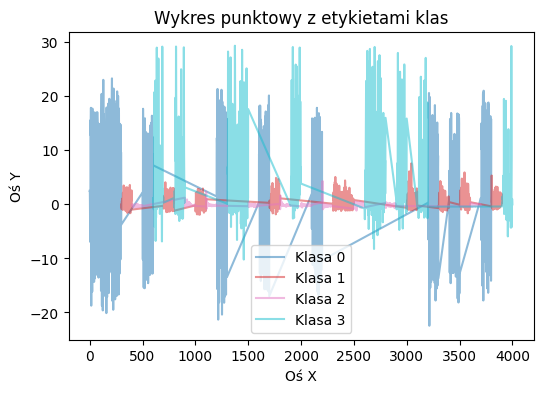

In [16]:
X = X_train
y = y_train_extended_list
# Ustalamy unikalne etykiety
unique_labels = np.unique(y)

# Wybieramy kolory dla każdej klasy
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Tworzenie wykresu punktowego
plt.figure(figsize=(6, 4))

for i, label in enumerate(unique_labels):
    # Wybieranie punktów dla danej klasy
    ix = np.array(np.where(label == y)).reshape(-1)
    mask = (y == label)
    plt.plot(ix, X[mask, 0], color=colors[i], label=f'Klasa {label}', alpha=0.5)

# Dodanie tytułu i etykiet osi
plt.title('Wykres punktowy z etykietami klas')
plt.xlabel('Oś X')
plt.ylabel('Oś Y')

# Dodanie legendy
plt.legend()

# Wyświetlenie wykresu
plt.show()

### Wizualizacja danych

In [17]:
# Visualise Loaded Data
def visualise_loaded_data(data):
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Plot different data on each subplot
    axs[0, 0].plot(data[:,0])
    axs[0, 0].set_title('accelerometer X')

    axs[0, 1].plot(data[:,1])
    axs[0, 1].set_title('accelerometer Y')

    axs[0, 2].plot(data[:,2])
    axs[0, 2].set_title('accelerometer Z')

    axs[1, 0].plot(data[:,3])
    axs[1, 0].set_title('gyroscope X')

    axs[1, 1].plot(data[:,4])
    axs[1, 1].set_title('gyroscope Y')

    axs[1, 2].plot(data[:,5])
    axs[1, 2].set_title('gyroscope Z')

    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# Visualise Loaded Data
def visualise_loaded_data(data):
    # Create a 2x3 grid of subplots
    c = data.shape[1]
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(c):
        # Plot different data on each subplot
        axs[int(i/3), i%3].plot(data[:,i])
        axs[int(i/3), i%3].set_title(f'param {i}')
        
    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

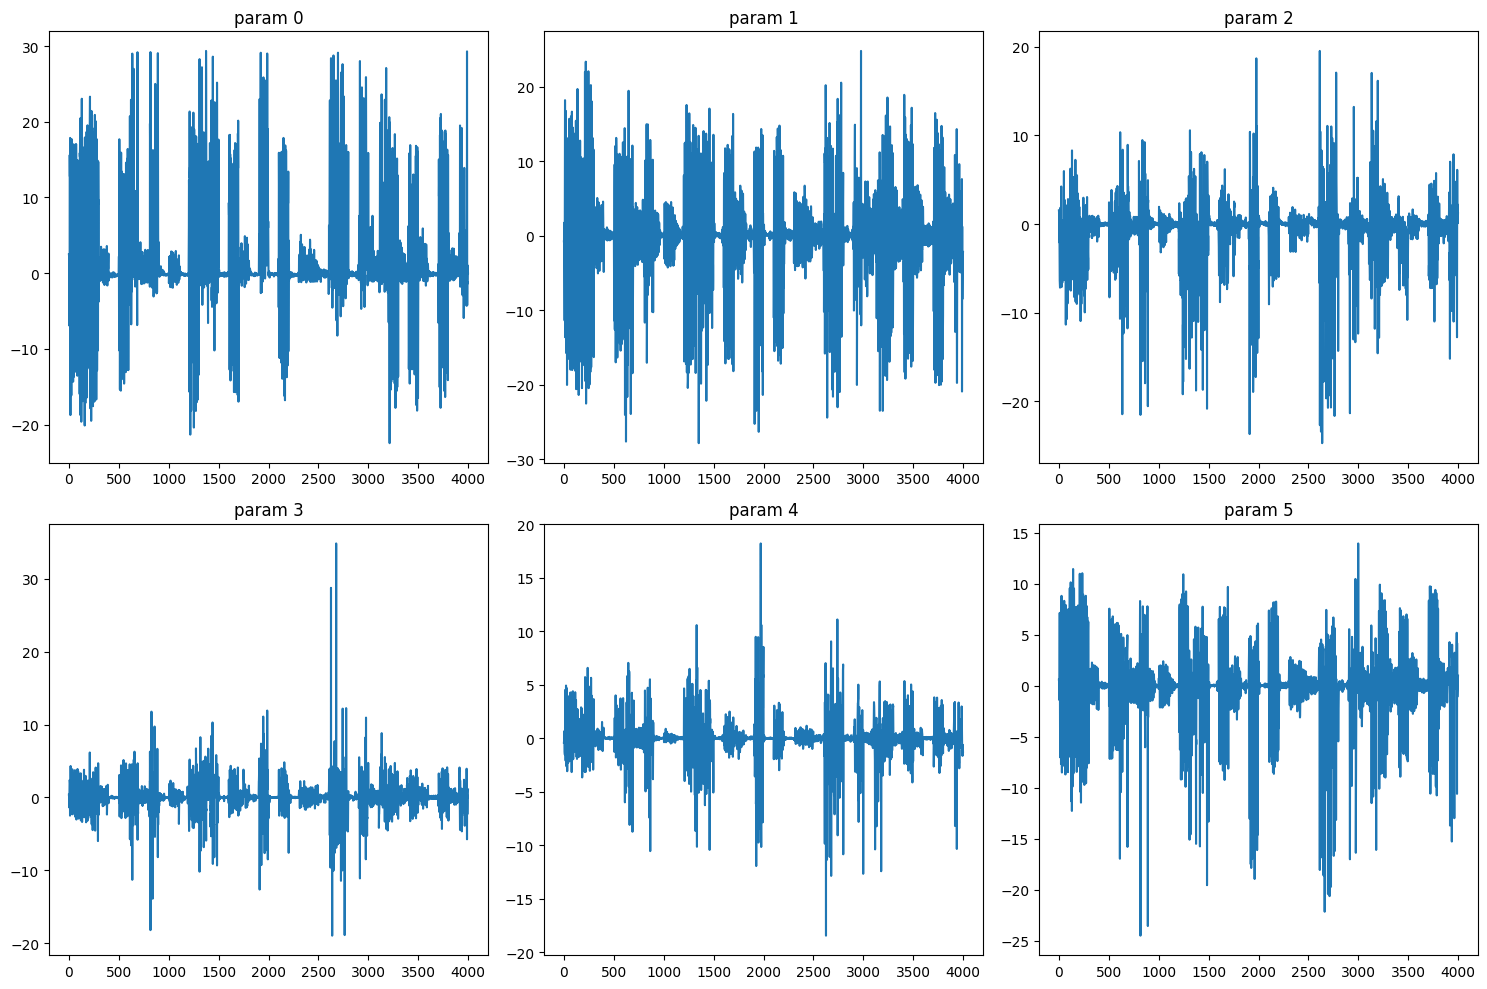

In [18]:
visualise_loaded_data(X_train)

In [19]:
# Metoda tworząca z wektora labelów tablicę labelów potrzebną do implementacji algorytmu SSFCM.
def label_vector_to_matrix(y, n_clusters, label_level, procent_of_data):
    array = np.zeros((len(y), n_clusters))

    for i, element in enumerate(y):
        if(i > len(y)*procent_of_data):
            break
        if element>=0:
            array[i, element] = label_level
    return array

y_train_extended = label_vector_to_matrix(y_train_extended_list, n_clusters, 0.8, injection)

In [20]:
# Rozmiary kolejnych chunków, mogą mieć różne wielkości. Następnie ze względu na te liczby dzielone są chunki
chunk_sizes = [chunk_length for i in range(0,int(X_train.shape[0]/chunk_length))]
chunks = []
chunks_y = []
start = 0
for size in chunk_sizes:
    end = start + size
    chunks.append(X_train[start:end])
    chunks_y.append(y_train_extended[start:end])
    start = end

# Metody klastrujące biblioteczne

### Fuzzy cmeans

In [21]:
# Funkcja do trenowania modelu Fuzzy C-Means
def first_train_fuzzy_c_means(X_train, n_clusters):
    # Trenowanie modelu Fuzzy C-Means
    cntr, u, u0, d, jm, p, fpc = cmeans(X_train, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

    # Przypisanie każdej próbki do klastra
    cluster_labels = np.argmax(u, axis=0)

    return cntr, u, cluster_labels, fpc


# Funkcja do trenowania modelu Fuzzy C-Means
def another_train_fuzzy_c_means(X_train, n_clusters, prev_c_matrix):
    # Trenowanie modelu Fuzzy C-Means
    cntr, u, u0, d, jm, p, fpc = cmeans(X_train, c=n_clusters, m=2, error=0.005, maxiter=1000, init=prev_c_matrix)

    # Przypisanie każdej próbki do klastra
    cluster_labels = np.argmax(u, axis=0)

    return cntr, u, u0, d, jm, fpc, p, cluster_labels

# Funkcja do predykcji klas za pomocą Fuzzy C-Means
def predict_fuzzy_c_means(X_test, cntr):
    # Obliczanie odległości i przypisywanie klas
    labels, _ = pairwise_distances_argmin_min(X_test, cntr)
    
    return labels


# Algorytm ISSFCM

In [22]:
from scipy.spatial.distance import cdist
from libraries.diagnosis_tools import DiagnosisTools, Multilist
from libraries.IFCM import incremental_fuzzy_cmeans_predict

In [23]:
import unittest

In [24]:
class TestFuzzyCMeans(unittest.TestCase):

    def setUp(self):
        # Przykładowe dane testowe
        self.data = np.random.rand(100, 2)  # 100 punktów, 2 cechy
        self.c = 3
        self.m = 2.0
        self.error = 1e-5
        self.maxiter = 100
        self.metric = 'euclidean'

    def test_choose_random_rows(self):
        selected_rows = choose_random_rows(self.data, self.c)
        self.assertEqual(selected_rows.shape[0], self.c)
        self.assertEqual(selected_rows.shape[1], self.data.shape[1])

    def test_initialize_c_first_centroids(self):
        centroids = initialize_c_first_centroids(self.data, self.c)
        self.assertEqual(centroids.shape[0], self.c)
        self.assertEqual(centroids.shape[1], self.data.shape[1])

    def test_initialize_average_c_centroids(self):
        y_train = np.random.randint(0, self.c, self.data.shape[0])
        centroids = initialize_average_c_centroids(self.data, y_train, self.c)
        self.assertEqual(centroids.shape[0], self.c)
        self.assertEqual(centroids.shape[1], self.data.shape[1])

    def test_create_labels(self):
        centroids = initialize_c_first_centroids(self.data, self.c)
        fuzzy_labels = create_labels(self.data, centroids, self.metric, self.m)
        self.assertEqual(fuzzy_labels.shape[0], self.c)
        self.assertEqual(fuzzy_labels.shape[1], self.data.shape[0])

    def test_distance_function(self):
        centroids = initialize_c_first_centroids(self.data, self.c)
        dist = _distance(self.data, centroids, self.metric)
        self.assertEqual(dist.shape[0], self.c)
        self.assertEqual(dist.shape[1], self.data.shape[0])

    def test_cmeans0(self):
        centroids = initialize_c_first_centroids(self.data, self.c)
        centroids, fuzzy_labels, jm, dist = cmeans0(self.data, centroids, self.metric, self.c, self.m)
        self.assertEqual(centroids.shape[0], self.c)
        self.assertEqual(centroids.shape[1], self.data.shape[1])
        self.assertEqual(fuzzy_labels.shape[0], self.c)
        self.assertEqual(fuzzy_labels.shape[1], self.data.shape[0])
        self.assertEqual(dist.shape[0], self.c)
        self.assertEqual(dist.shape[1], self.data.shape[0])

    def test_fp_coeff(self):
        fuzzy_labels = np.random.rand(self.c, self.data.shape[0])
        fpc = _fp_coeff(fuzzy_labels)
        self.assertIsInstance(fpc, float)

    def test_fuzzy_cmeans(self):
        centroids, fuzzy_labels, dist, p, fpc, statistics = fuzzy_cmeans(self.data, self.c, self.m, self.error, self.maxiter, self.metric)
        self.assertEqual(centroids.shape[0], self.c)
        self.assertEqual(centroids.shape[1], self.data.shape[1])
        self.assertEqual(fuzzy_labels.shape[0], self.c)
        self.assertEqual(fuzzy_labels.shape[1], self.data.shape[0])
        self.assertEqual(dist.shape[0], self.c)
        self.assertEqual(dist.shape[1], self.data.shape[0])
        self.assertIsInstance(fpc, float)
        self.assertTrue(p <= self.maxiter)
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

EEEEEEEE
ERROR: test_choose_random_rows (__main__.TestFuzzyCMeans.test_choose_random_rows)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\kubak\AppData\Local\Temp\ipykernel_14516\748364304.py", line 13, in test_choose_random_rows
    selected_rows = choose_random_rows(self.data, self.c)
                    ^^^^^^^^^^^^^^^^^^
NameError: name 'choose_random_rows' is not defined

ERROR: test_cmeans0 (__main__.TestFuzzyCMeans.test_cmeans0)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\kubak\AppData\Local\Temp\ipykernel_14516\748364304.py", line 41, in test_cmeans0
    centroids = initialize_c_first_centroids(self.data, self.c)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'initialize_c_first_centroids' is not defined

ERROR: test_create_labels (__main__.TestFuzzyCMeans.test_create_labels)
------------------------------------

### Algorytm semi-nadzorowany inkrementacyjny

##### Normalizowanie kolumn

In [25]:
import numpy as np

def normalize_columns(columns):
    # broadcast sum over columns
    normalized_columns = columns/np.sum(columns, axis=0, keepdims=1)

    return normalized_columns

def reflect_labels(y):
    result = 1 - np.sum(y, axis=0, keepdims=1)
    
    return result

def normalize_power_columns(x, exponent):
    assert np.all(x >= 0.0)

    x = x.astype(np.float64)

    # values in range [0, 1]
    x = x/np.max(x, axis=0, keepdims=True)

    # values in range [eps, 1]
    x = np.fmax(x, np.finfo(x.dtype).eps)

    if exponent < 0:
        # values in range [1, 1/eps]
        x /= np.min(x, axis=0, keepdims=True)

        # values in range [1, (1/eps)**exponent] where exponent < 0
        # this line might trigger an underflow warning
        # if (1/eps)**exponent becomes zero, but that's ok
        x = x**exponent
    else:
        # values in range [eps**exponent, 1] where exponent >= 0
        x = x**exponent

    result = normalize_columns(x)

    return result



##### Trening

In [26]:
from scipy.spatial.distance import cdist
from libraries.diagnosis_tools import DiagnosisTools, Multilist

def choose_random_rows(array, c):
    if c > array.shape[0]:
        raise ValueError("Liczba wierszy do wybrania jest większa niż liczba dostępnych wierszy w tablicy.")
    
    # Wybór c unikalnych indeksów wierszy
    row_indices = np.random.choice(array.shape[0], c, replace=False)
    
    # Wybranie wierszy o wybranych indeksach
    selected_rows = array[row_indices]
    
    return selected_rows
    
def initialize_c_first_centroids(data, c):
    # Inicjalizuje biorąc pierwsze k punktów jako centroidy
    selected_rows = choose_random_rows(data, c)
    return selected_rows

def initialize_average_c_centroids(data, y_train, c):
    # Oblcza dla każdego segmentu średnią liczbę punktów
    
    return data[0:c,:]
    
def create_labels(data, y, centroids, metric, m):
    # Tablica dystansów
    dist = _distance(data, centroids, metric)

    # Tablica prawdopodobieństw z zwykłego algorytmu FCM
    fuzzy_labels = normalize_power_columns(dist, - 2. / (m - 1))

    
    # 1 - sum j = 1:C y(j)
    y_ = reflect_labels(y)
    y_ = np.tile(y_, (fuzzy_labels.shape[0], 1))

    fuzzy_labels = y + np.multiply(fuzzy_labels, y_)
    
    return fuzzy_labels

def _fp_coeff(u):
    # Mierzy rozmytość wyliczonych klastrów
    n = u.shape[1]
    
    return np.trace(u.dot(u.T)) / float(n)

def _distance(data, centroids, metric='euclidean'):
    # Oblicza dystans dla każdego punktu do każdego centroidu
    dist = cdist(data, centroids, metric=metric).T
    
    return np.fmax(dist, np.finfo(np.float64).eps)

def semi_supervised_cmeans0(data, y, centroids, metric, c, m):
    # Obliczanie tablicy dystansów
    dist = _distance(data, centroids, metric)

    # Obliczanie fuzzy_labels na podstawie centroidów i tablicy dystansów
    fuzzy_labels = create_labels(data, y, centroids, metric, m)

    fuzzy_labels_supervised = abs(fuzzy_labels - y)
    
    fuzzy_labels_supervised_m = fuzzy_labels_supervised ** m
    
    # Aktualizowanie centroidów
    centroids = fuzzy_labels_supervised_m.dot(data) / np.atleast_2d(fuzzy_labels_supervised_m.sum(axis=1)).T

    jm = (fuzzy_labels_supervised_m * dist ** 2).sum()
    
    return centroids, fuzzy_labels, jm, dist


def incremental_semi_supervised_fuzzy_cmeans(data, y, c, m, error, maxiter, metric = 'euclidean', init_centroid=None):
    # data jeste postaci (n_samples, k_features)
    # Rozmiar danych
    n = data.shape[0]
    
    # Liczba clustrów
    k = data.shape[1]
    
    # Struktura do której bedziemy zbierać informacje z każdej iteracji
    statistics = Multilist(['fpc'])
    
    centroids = init_centroid
    
    if(init_centroid is None):
        centroids = initialize_c_first_centroids(data, c)
        #centroids = initialize_average_c_centroids(data, y_train, k)
    
    fuzzy_labels = create_labels(data, y.T,  centroids, metric, m)

    # Initialize loop parameters
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        fuzzy_labels_copy = fuzzy_labels.copy()
        centroids_copy = centroids.copy()

        [centroids, fuzzy_labels, Jjm, dist] = semi_supervised_cmeans0(data, y.T, centroids_copy, metric, c, m)

        fpc = _fp_coeff(fuzzy_labels)
        statistics.add_elements([fpc])
        p += 1
        
        # Stopping rule
        if np.linalg.norm(fuzzy_labels - fuzzy_labels_copy) < error and p > 1:
            break
        if np.linalg.norm(centroids_copy - centroids) < error and p > 1:
            break
            
    # Final calculations
    error = np.linalg.norm(fuzzy_labels - fuzzy_labels_copy)
    fpc = _fp_coeff(fuzzy_labels)

    return centroids, fuzzy_labels, dist, p, fpc, statistics


##### Predykcja

In [27]:
def incremental_semi_supervised_fuzzy_cmeans_predict(test_data, cntr_trained, m, error, maxiter, metric='euclidean', init=None, seed=None):
    c = cntr_trained.shape[0]

    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = test_data.shape[1]
        u0 = np.random.rand(c, n)
        u0 = normalize_columns(u0)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [u, Jjm, d] = incremental_semi_supervised_cmeans_predict0(test_data, cntr_trained, u2, c, m, metric)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return u, u0, d, jm, p, fpc 
    
def incremental_semi_supervised_cmeans_predict0(test_data, cntr, u_old, c, m, metric):

    # Normalizing, then eliminating any potential zero values.
    u_old = normalize_columns(u_old)
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m
    test_data = test_data.T

    # For prediction, we do not recalculate cluster centers. The test_data is
    # forced to conform to the prior clustering.

    d = _distance(test_data, cntr, metric)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = normalize_power_columns(d, - 2. / (m - 1))

    return u, jm, d

# Metody wizualizacji danych

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import random

### Redukcja wymiarowości

In [29]:
def simple_plot(X, cntr, cluster_labels, name):
    n_clusters = cntr.shape[0]
    if X.shape[1] > 2:
        # Jeżeli dane mają więcej niż 2 wymiary, to można redukować ich wymiarowość. 
        # Zwracamy zatem True, aby użyć algorytmu redukującego wymiarowość
        return True
    
    elif X.shape[1] == 2:
        # Tworzymy wykres dla danych 2 wymiarowych
        # Wizualizacja klastrów
        plt.figure(figsize=(10, 8))
        for i in range(n_clusters):
            plt.scatter(X[cluster_labels == i, 0], X[cluster_labels == i, 1], label=f'Cluster {i+1}')
    
        # Dodanie centrów klastrów do wykresu
        plt.title('Fuzzy C-Means Clustering 2D ' + name)
        plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', s=200, c='black', label='Cluster Centers')
    
    elif X.shape[1] == 1:
        #Losujemy liste kolorow
        colors_list = list(plt.cm.tab10.colors)
        
        # Tworzymy wykres dla danych jednowymiarowych
        plt.figure(figsize=(10, 8))
        plt.title('Fuzzy C-Means Clustering 1D ' + name)
        for i in range(n_clusters):       
            plt.plot(np.array(np.where(cluster_labels == i)).reshape(-1), X[cluster_labels == i, 0], label=f'Cluster {i+1}', color=colors_list[i], marker='o')
    else:
        print('Zły wymiar danych, plot function')
        return False
        
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    return False

def plot_pca(X, cntr, cluster_labels):
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(X, cntr, cluster_labels, 'pca')
    
    # Redukcja wymiarowości za pomocą PCA do 2 wymiarów
    if data_type:
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(X)
    
        # Redukcja wymiarowości centrów klastrów
        cntr_pca = pca.transform(cntr)
        
        # Wizualizacja klastrów
        plt.figure(figsize=(10, 8))
        for i in range(n_clusters):
            plt.scatter(data_pca[cluster_labels == i, 0], data_pca[cluster_labels == i, 1], label=f'Cluster {i+1}')
    
        # Dodanie centrów klastrów do wykresu
        plt.title('Fuzzy C-Means Clustering (PCA Reduced Data)')
        plt.scatter(cntr_pca[:, 0], cntr_pca[:, 1], marker='x', s=200, c='black', label='PCA Cluster Centers')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()

def plot_heatmap(data, centroids, labels):    
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, labels, 'heatmap')

    if(data_type):
        combined_data = np.vstack([data, centroids])
        combined_labels = np.hstack([labels, [-1] * len(centroids)])  # -1 dla centroidów
    
        plt.figure(figsize=(12, 8))
        sns.heatmap(combined_data, cmap='coolwarm', xticklabels=False, yticklabels=False)
        plt.title('Heatmap of Data and Centroids')
        plt.show()

def plot_tsne(data, centroids, labels):
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, labels, 'tsne')

    if(data_type):
        combined_data = np.vstack([data, centroids])
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(combined_data)
    
        plt.figure(figsize=(10, 6))
        plt.scatter(tsne_results[:-len(centroids), 0], tsne_results[:-len(centroids), 1], c=labels, cmap='viridis', label='Data')
        plt.scatter(tsne_results[-len(centroids):, 0], tsne_results[-len(centroids):, 1], c='red', label='Centroids', marker='X', s=100)
        plt.legend()
        plt.colorbar()
        plt.title('t-SNE Plot of Data and Centroids')
        plt.show()


def plot_mds(data, centroids, labels):
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, labels, 'mds')

    if(data_type):
        combined_data = np.vstack([data, centroids])
        mds = MDS(n_components=2, random_state=42)
        mds_results = mds.fit_transform(combined_data)
    
        plt.figure(figsize=(10, 6))
        plt.scatter(mds_results[:-len(centroids), 0], mds_results[:-len(centroids), 1], c=labels, cmap='viridis', label='Data')
        plt.scatter(mds_results[-len(centroids):, 0], mds_results[-len(centroids):, 1], c='red', label='Centroids', marker='X', s=100)
        plt.legend()
        plt.colorbar()
        plt.title('MDS Plot of Data and Centroids')
        plt.show()

    

### Wizualizacja zestawów danych

In [30]:

def plot_centroids(centroids):
    # Przeprowadzenie PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(centroids)

    colors_list = list(plt.cm.tab10.colors)
    
    # Wykres PCA
    plt.figure(figsize=(10, 5))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c = colors_list[:data_pca.shape[0]], cmap='viridis')
    plt.colorbar(label='Czas')
    plt.xlabel('Główna składowa 1')
    plt.ylabel('Główna składowa 2')
    plt.title('Wizualizacja centroidów startowych PCA')
    plt.grid(True)
    plt.show()



def plot_two(data, centroids, cluster_labels, plot1, plot2):
    plot1(data, cntr, cluster_labels)
    plot2(data, cntr, cluster_labels)

def visualize_all(data, centroids, cluster_labels):
    # Wizualizacja dla pierwszej iteracji
    print('PCA plot')
    plot_pca(data, centroids, cluster_labels)
    print('heatmap plot')
    plot_heatmap(data, centroids, cluster_labels)
    print('TSNE plot')
    plot_tsne(data, centroids, cluster_labels)
    print('MDS plot')
    plot_mds(data, centroids, cluster_labels)

def prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations):
    chunk_lists = diagnosis_chunk.get_lists()
    
    lists_amount =len(diagnosis_iterations[0].get_lists())
    
    iter_lists = []
    iter_lists_concatenate = []
    
    for i in range(0,lists_amount):
        iter_lists.append([])
        iter_lists_concatenate.append([])
        
    for di in diagnosis_iterations:
        lists = di.get_lists()
        for i, list_ in enumerate(lists):
            iter_lists[i].append(list_)
            iter_lists_concatenate[i] = iter_lists_concatenate[i] + list_
    return chunk_lists, iter_lists, iter_lists_concatenate
                        
# Funkcja wyświetla historię rozwoju algorytmu IFCM (i jego odmian)
def overview_plot(diagnosis_chunk, diagnosis_iterations, n_centroids_history=5):
    print('Historia danych ze względu na kolejne chunki')
    diagnosis_chunk.plot_lists('Historia danych ze względu na kolejne chunki')
    print('Historia danych wewnatrz iteracji dla pierwszego chunka')
    diagnosis_iterations[0].plot_lists('Historia danych wewnatrz iteracji dla pierwszego chunka')
    print('Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku')
    chunk_lists, iter_lists, iter_lists_concatenate = prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations)
    plot_lists_inside_lists(chunk_lists, iter_lists, 'Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku')
    print('Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku')
    plot_multiple_functions([(iter_lists_concatenate[0],'fpc')], 'Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku')
    print('chunk_length', chunk_length)
    print('n_clusters', n_clusters)
    print('m',m)
    diagnosis_chunk.plot_centroid_history(n_centroids_history)

# Funkcje wyświetla wiele funkcji na jednym wykresie. 
# Input: args to lista par (lista, nazwa)
def plot_multiple_functions(args, title='multiple functions'):

    plt.figure(figsize=(10, 6))
    
    for y_values, label in args:
        x_values = list(range(len(y_values)))  # Zakładamy, że x to indeksy listy y
        plt.plot(x_values, y_values, label=label)
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Funkcja do tworzenia wykresu
def plot_lists_inside_lists(first_class_lists, second_class_lists, title='Plot of First Class and Second Class Lists'):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Wykres list pierwszej klasy
    for i, first_list in enumerate(first_class_lists):
        ax.plot(first_list, marker='o')
        
        # Wykresy list drugiej klasy dla każdej listy pierwszej klasy

    for i in range(len(second_class_lists)):
        for j in range(len(first_class_lists[0]) - 1):
            second_list = second_class_lists[i][j]
            x_vals = np.linspace(j, j+1, len(second_list))
            y_vals = np.array(second_list)

            ax.plot(x_vals, y_vals)
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.show()

# Predykcja i Validacja danych

In [31]:
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import rand_score

### Validacja

In [32]:
def most_frequent_in_segments(array, segment_length=100):
    # Sprawdzenie czy tablica ma odpowiedni rozmiar
    if len(array) % segment_length != 0:
        raise ValueError(f"Array length must be a multiple of {segment_length}.")
    
    # Podział tablicy na segmenty
    segments = [array[i:i + segment_length] for i in range(0, len(array), segment_length)]
    
    # Przechowywanie wyników
    results = []

    for segment in segments:
        # Znajdź najczęściej występującą wartość i jej liczbę wystąpień
        counter = Counter(segment)
        most_common_value, count = counter.most_common(1)[0]
        results.append((most_common_value, count))
    
    return results
    
def classify_data_segment(data, cluster_membership, time_segment=100):
    
    results = most_frequent_in_segments(cluster_membership, time_segment)

    results_ = [int(result[0])  for result in results]

    # Zwraca klasę dla każdego odcinku czasowego wielkości time_segment klatek
    return results_
    
    
def valid_data(data_test, centroids, y_extended, m, g_error):

    u, u0, d, jm, p, fpc = incremental_fuzzy_cmeans_predict(data_test.T, centroids, m=m, error=g_error, maxiter=1000, metric='euclidean', init=None)
    cluster_membership = np.argmax(u, axis=0)

    # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)
    
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    
    return  silhouette_avg, davies_bouldin_avg, rand, fpc



### Predykcja

# Testowanie algorytmu IFCM

### Implementacja algorytmów

In [33]:
from tqdm import tqdm
from IPython.display import clear_output
import time
import sys
import statistics
from libraries.IFCM import incremental_fuzzy_cmeans

In [34]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_data - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans(n_clusters, chunks, validation_data, y_valid_extended, visualise_data=False):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=None)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data(validation_data, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)
    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        cluster_labels = np.argmax(fuzzy_labels, axis=0)
        visualize_all(data, centroids, cluster_labels)
    
    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)

        # Wizualizacja dla pierwszej iteracji
        cluster_labels = np.argmax(fuzzy_labels, axis=0)

        if(visualise_data):
            plot_pca(data, centroids, cluster_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data(validation_data, centroids, y_valid_extended, m, g_error)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

In [35]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Z kazdą iteracją algorytmu dodawane sa kolejne chunki (punkty danych). 
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_data - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks, validation_data, y_valid_extended, visualise_data=False):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=None)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data(validation_data, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)
    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, np.argmax(fuzzy_labels, axis=0))
    
    # Kolejne trenowanie modelu
    for count, chunk in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        data = np.vstack((data, chunk))
        
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)

        if(visualise_data):
            plot_pca(data, centroids, np.argmax(fuzzy_labels, axis=0))

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data(validation_data, centroids, y_valid_extended, m, g_error)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

In [36]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Z kazdą iteracją algorytmu dodawane sa kolejne chunki (punkty danych) do pewnej określonej wielkości, po przekroczeniu tej wielkości dane są aktualizowane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_data - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans_extending_window_data(n_clusters, chunks, validation_data, y_valid_extended, visualise_data=False, window_size = 5):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=None)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data(validation_data, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)
    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, np.argmax(fuzzy_labels, axis=0))

    data = [data]
    # Kolejne trenowanie modelu
    for count, chunk in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        data.append(chunk)

        if len(data) > window_size:
            del data[0]
        
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(np.concatenate(data), c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)

        if(visualise_data):
            plot_pca(data, centroids, np.argmax(fuzzy_labels, axis=0))

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data(validation_data, centroids, y_valid_extended, m, g_error)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

### Trenowanie przy pomocy iterowania się po chunkach

In [37]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans(n_clusters, chunks, X_test, y_test_extended)

Rozważamy obecnie chunk numer:  39
Liczba klastrów:  4


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<?, ?it/s]


Historia danych ze względu na kolejne chunki


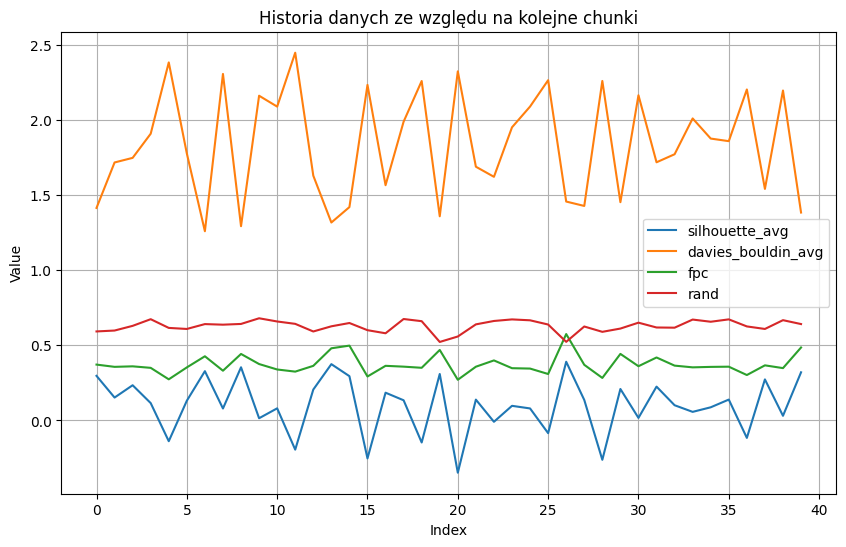

Historia danych wewnatrz iteracji dla pierwszego chunka


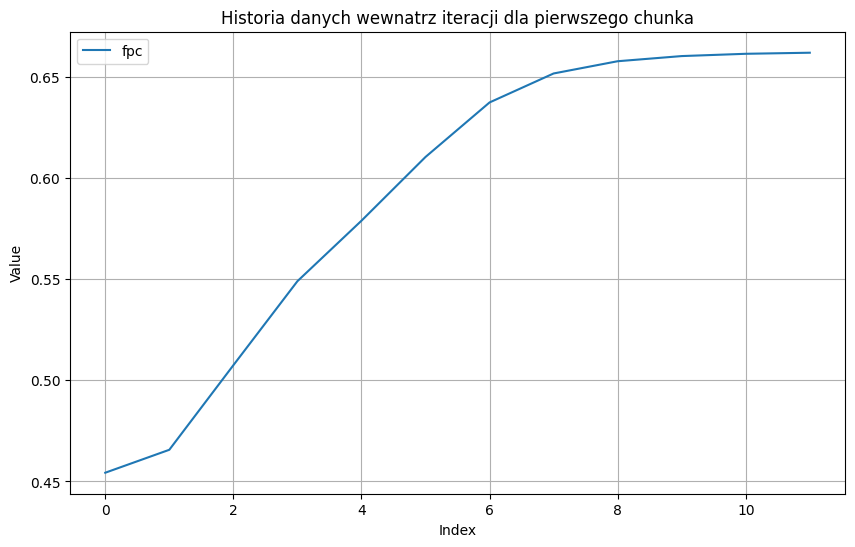

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


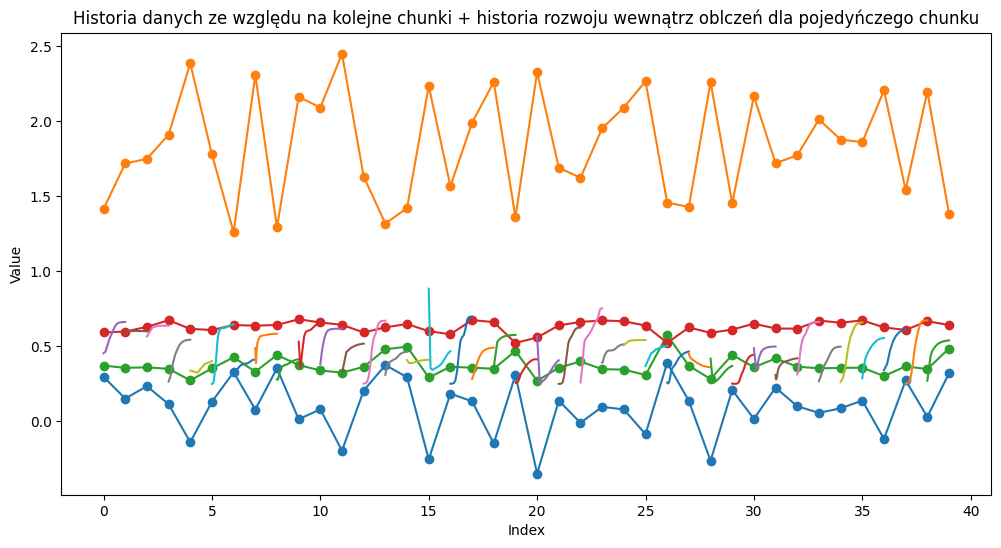

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


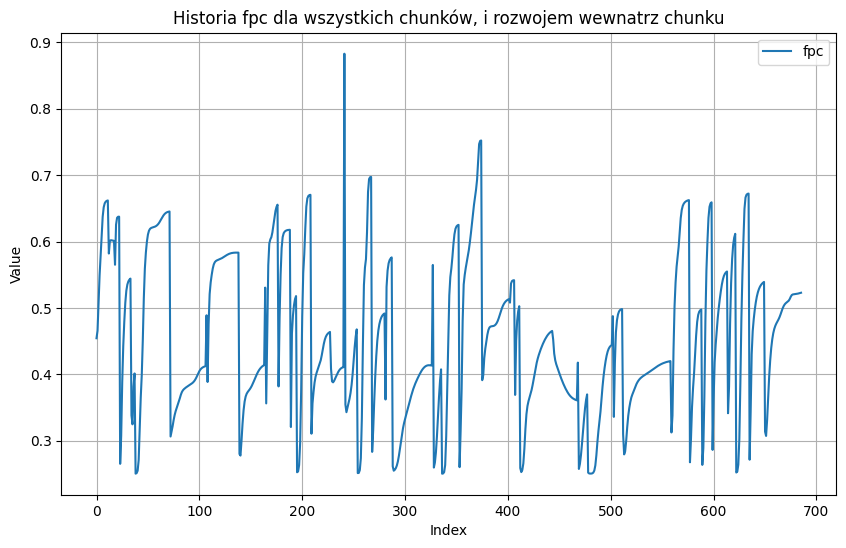

chunk_length 100
n_clusters 4
m 2


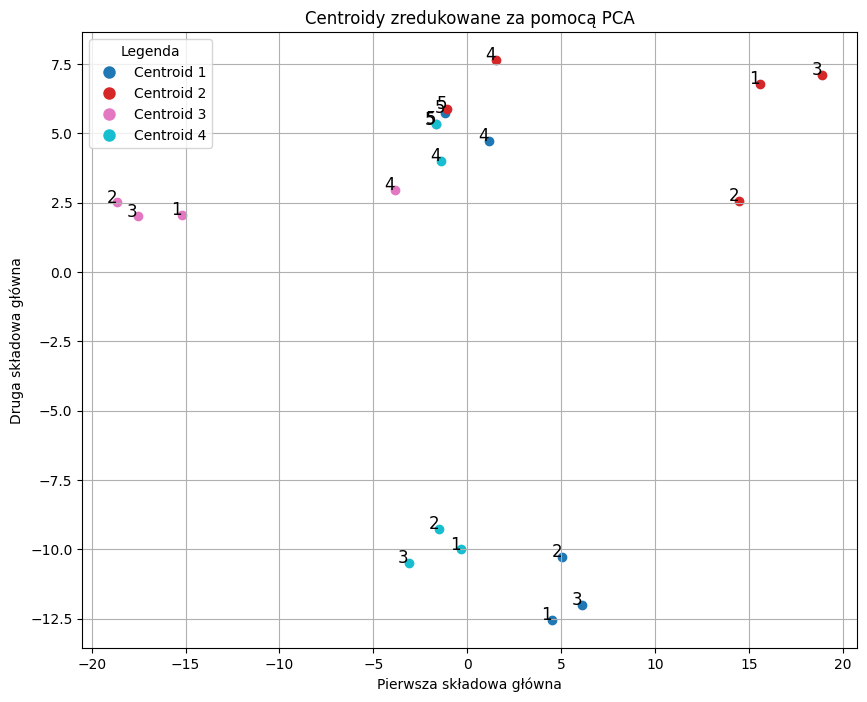

In [38]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi

In [39]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks, X_test, y_test_extended)

Rozważamy obecnie chunk numer:  39
Liczba klastrów:  4


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<?, ?it/s]


Historia danych ze względu na kolejne chunki


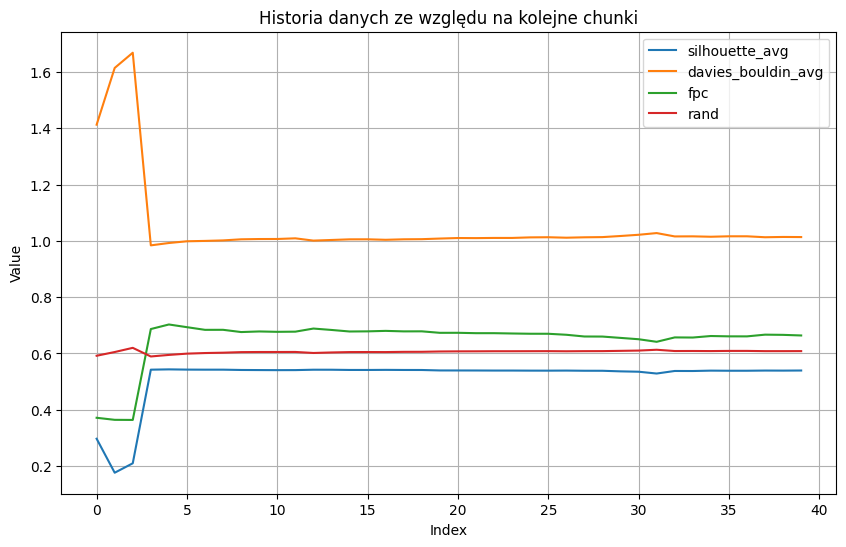

Historia danych wewnatrz iteracji dla pierwszego chunka


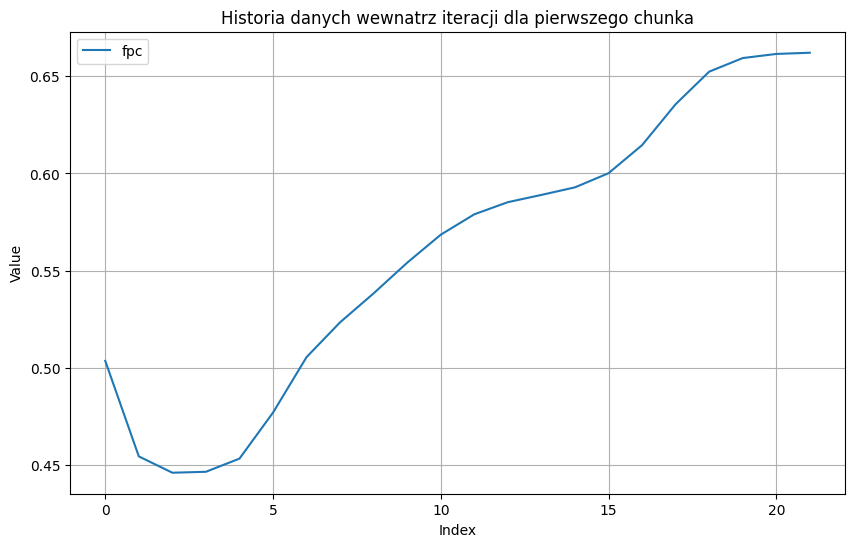

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


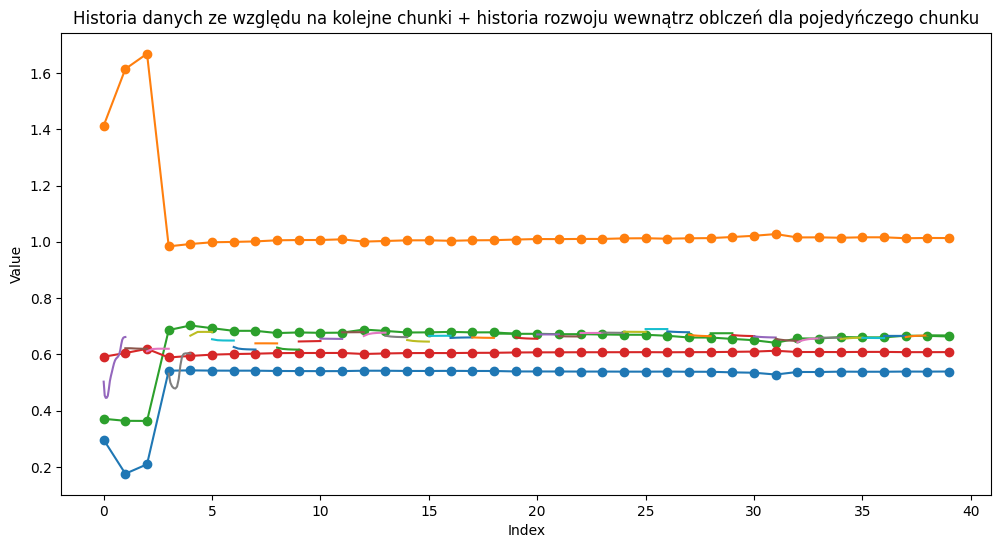

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


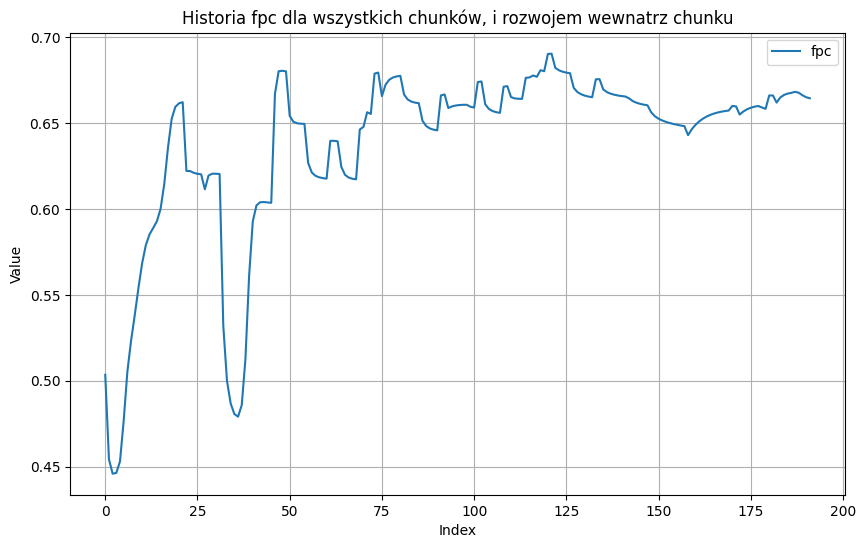

chunk_length 100
n_clusters 4
m 2


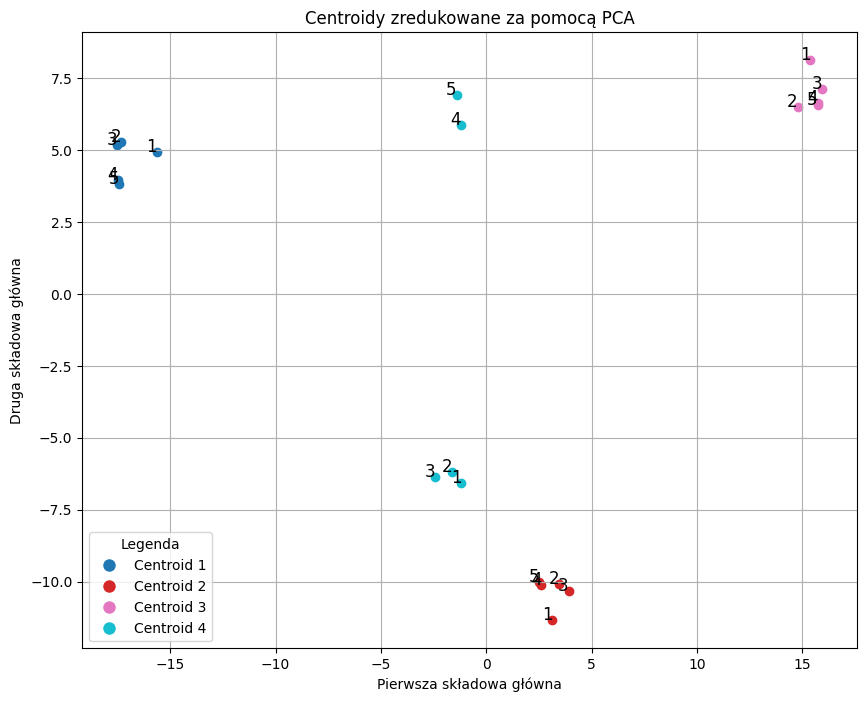

In [40]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi, przesuwającym się oknem

In [41]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_window_data(n_clusters, chunks, X_test, y_test_extended)

Rozważamy obecnie chunk numer:  39
Liczba klastrów:  4


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<?, ?it/s]


Historia danych ze względu na kolejne chunki


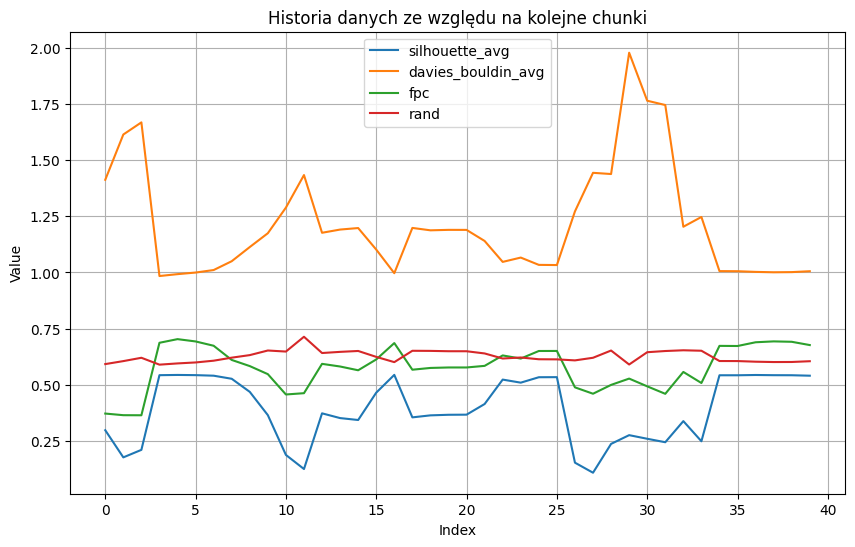

Historia danych wewnatrz iteracji dla pierwszego chunka


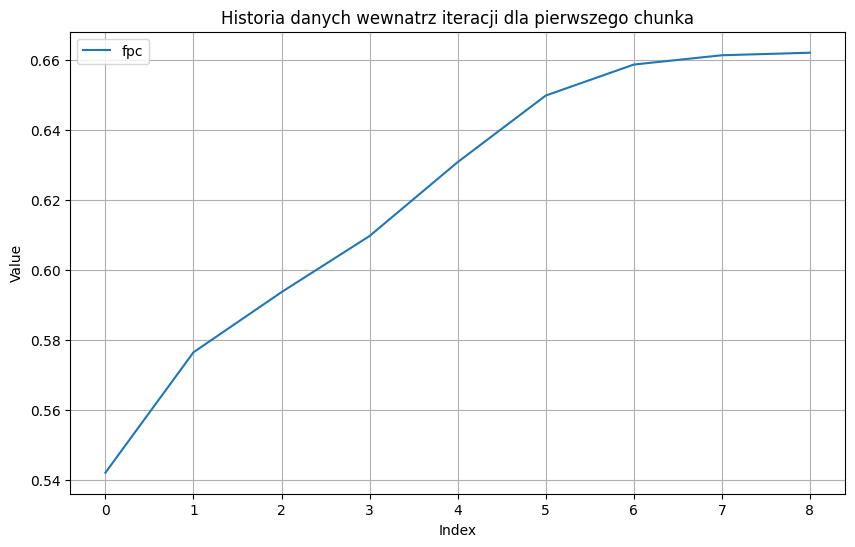

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


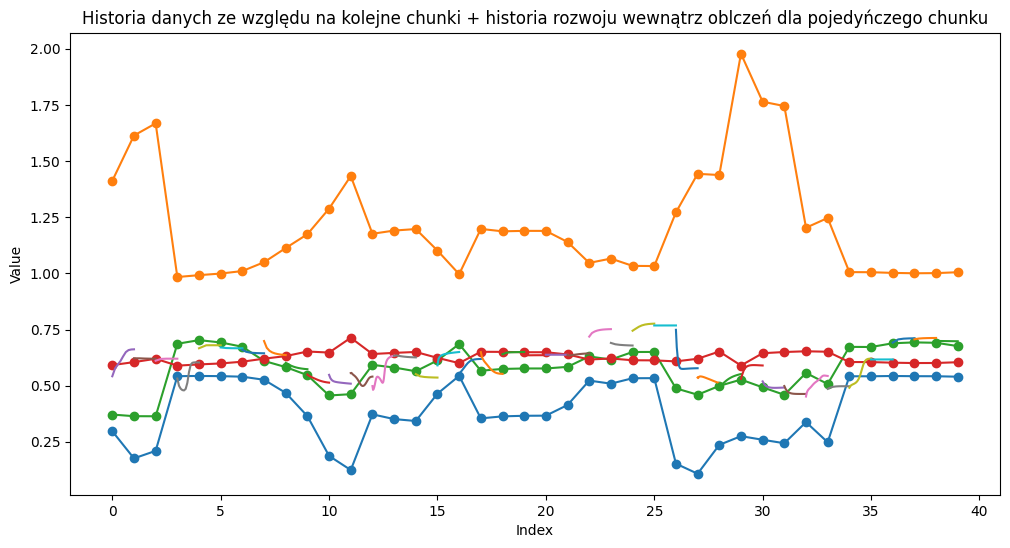

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


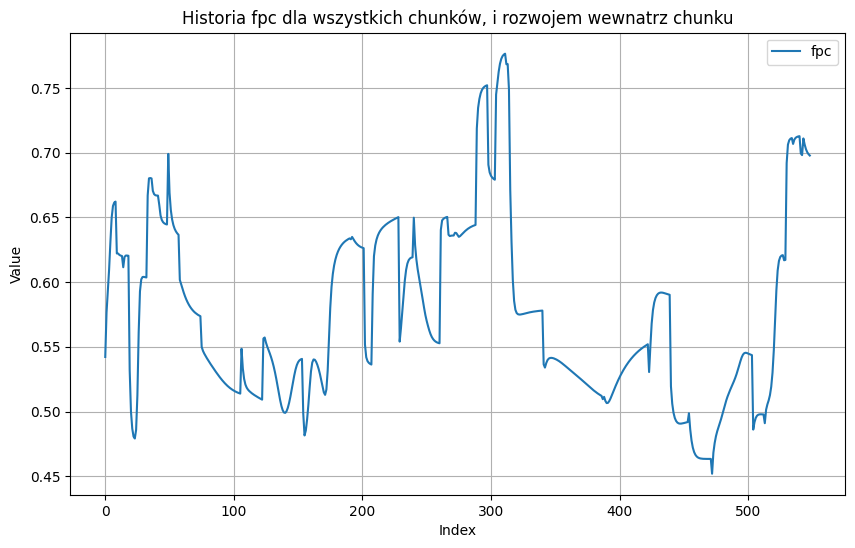

chunk_length 100
n_clusters 4
m 2


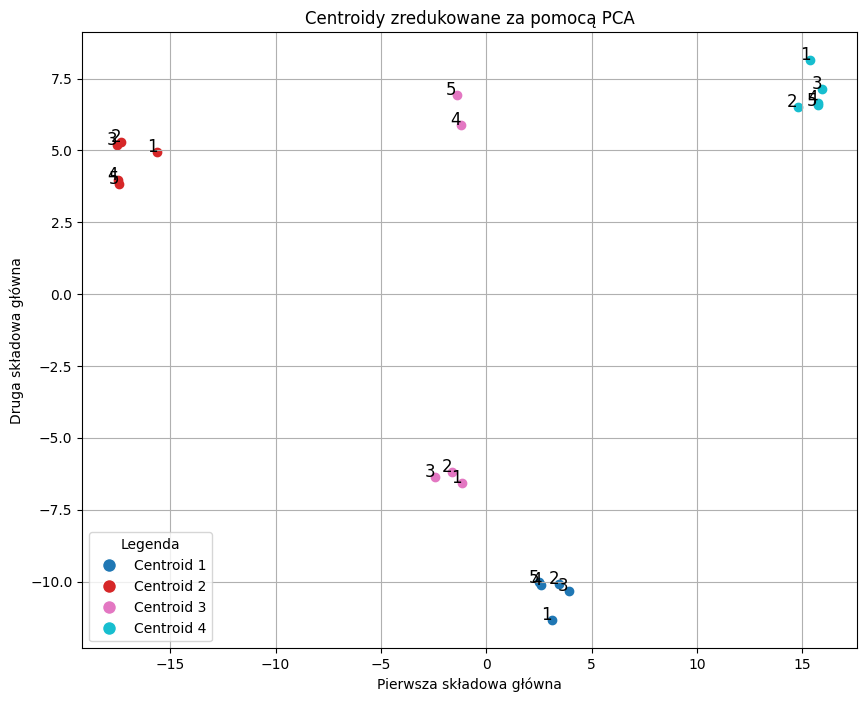

In [42]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Historia ewolucji centroidów

In [43]:
first_diagnosis_tools, first_diagnosis_iterations = train_incremental_fuzzy_cmeans(n_clusters, chunks, X_test, y_test_extended)

Rozważamy obecnie chunk numer:  39
Liczba klastrów:  4


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<?, ?it/s]


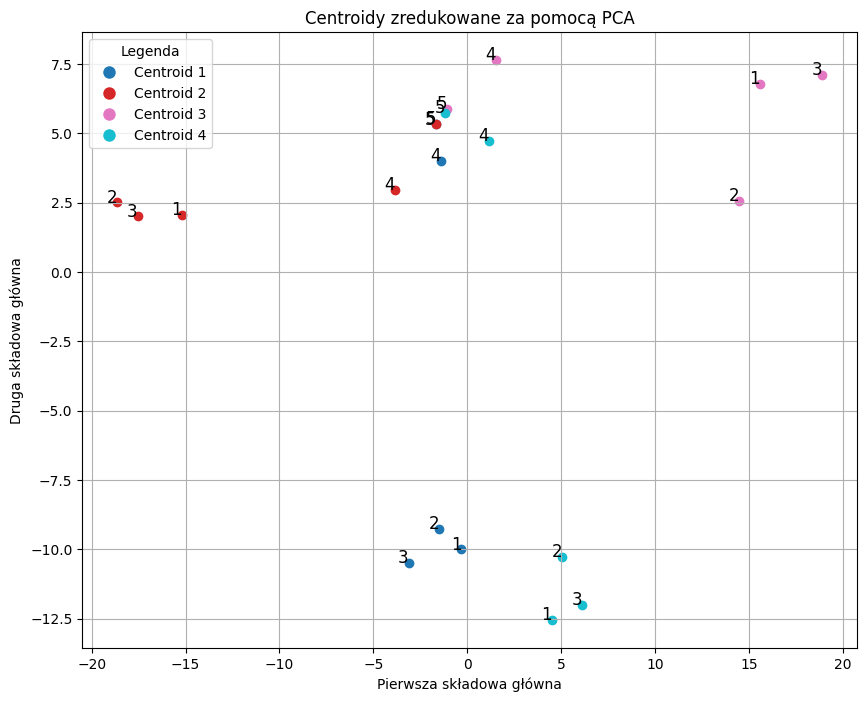

In [44]:
first_diagnosis_tools.plot_centroid_history(5)

### Badania zachowania się metody ze względu na liczbę clustrów



In [45]:
output_data_chunk = []
output_data_iter = []
for n in range(2,10):
    print('Rozważam: ', n)
    diagnosis_tools, diagnosis_iterations = train_incremental_fuzzy_cmeans(n, chunks, X_test, y_test_extended)
    output_data_chunk.append(diagnosis_tools)
    output_data_iter.append(diagnosis_iterations)

Rozważamy obecnie chunk numer:  39
Liczba klastrów:  9


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<?, ?it/s]


In [46]:
plot_statistic = DiagnosisTools()

for n in range(2,10):
    sil, dave, fpc, rand = output_data_chunk[n-2].get_avg()
    plot_statistic.add_elements(sil, dave, fpc, rand)

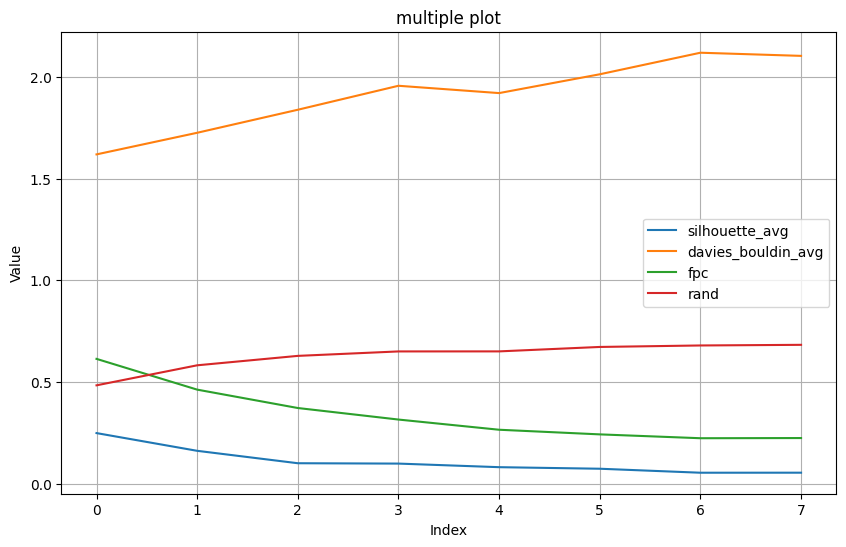

In [47]:
plot_statistic.plot_lists()

# Testowanie algorytmu ISSFCM

### Trenowanie przy pomocy dodawania kolejnych chunków

fpc of first chunk 0.7370939332254123
Silhouette Score: 0.30175462701273875
Davies-Bouldin Score: 1.4083736038200498
Rand Score: 0.590053888472118
Tested fpc: 0.37194320441579926
PCA plot


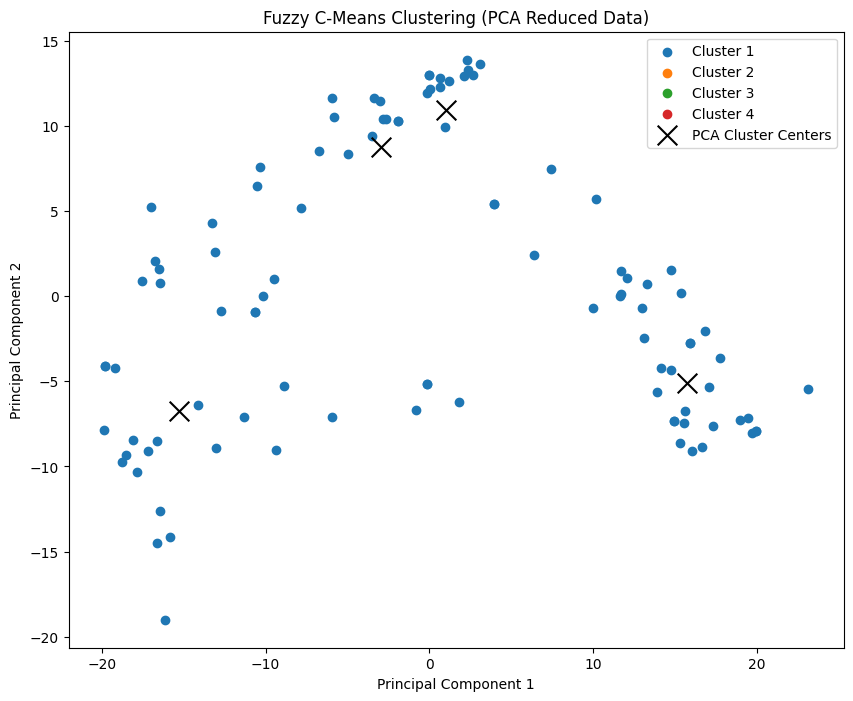

heatmap plot


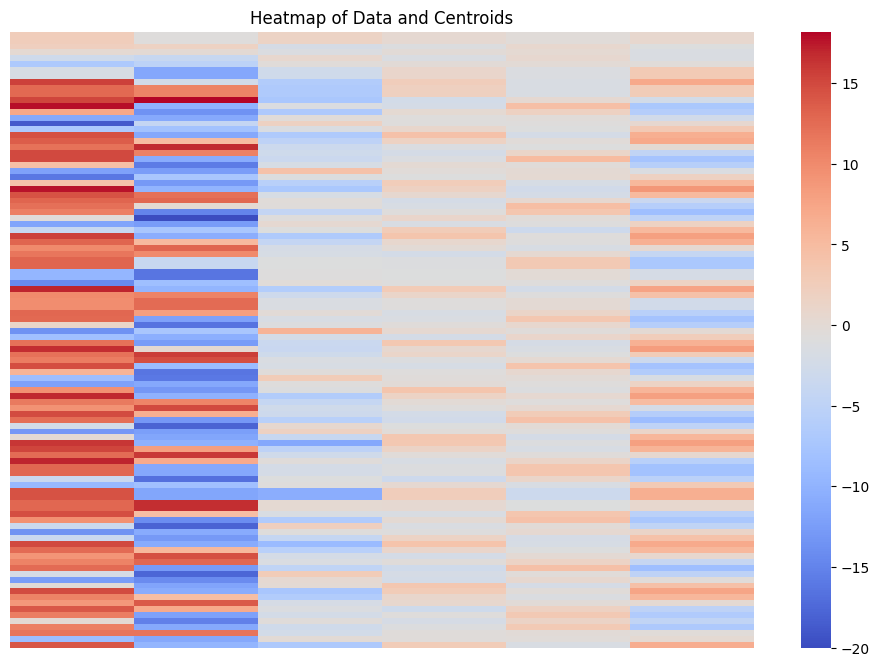

TSNE plot


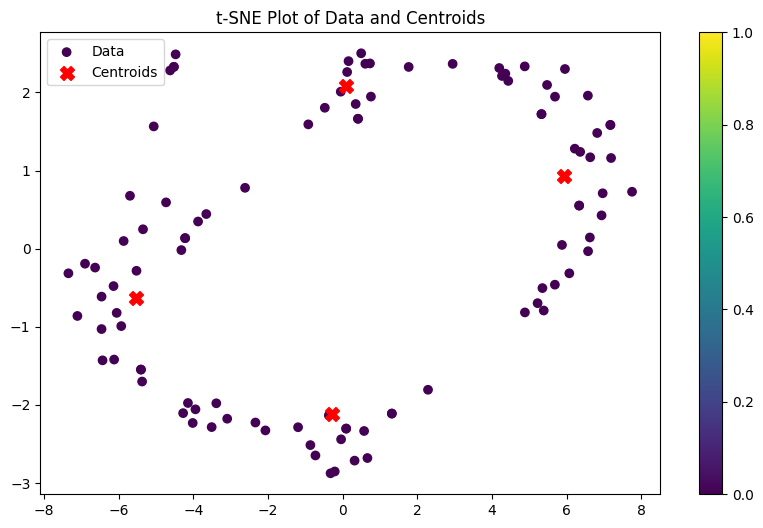

MDS plot


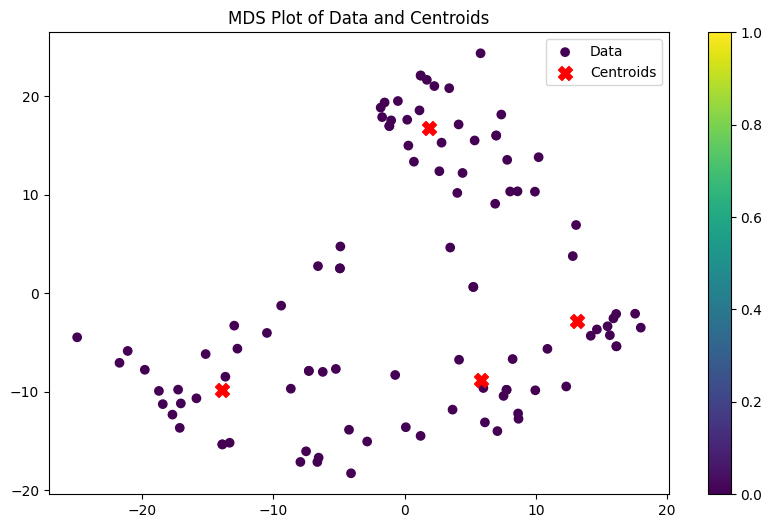

In [48]:
data = chunks[0]
y_supervised = chunks_y[0]
data.shape

centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_semi_supervised_fuzzy_cmeans(data, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=None)

print('fpc of first chunk', fpc)
diagnosis_chunk = DiagnosisTools()
sil, dav, rand, fpc_test = valid_data(X_test, centroids, y_test_extended, m, g_error)
diagnosis_chunk.add_elements(sil, dav, rand, fpc_test)

# Wizualizacja dla pierwszej iteracji
cluster_labels = np.argmax(fuzzy_labels, axis=0)
visualize_all(data, centroids, cluster_labels)


Przetwarzamy chunk  1
p 3
fpc () 0.7329038614313375


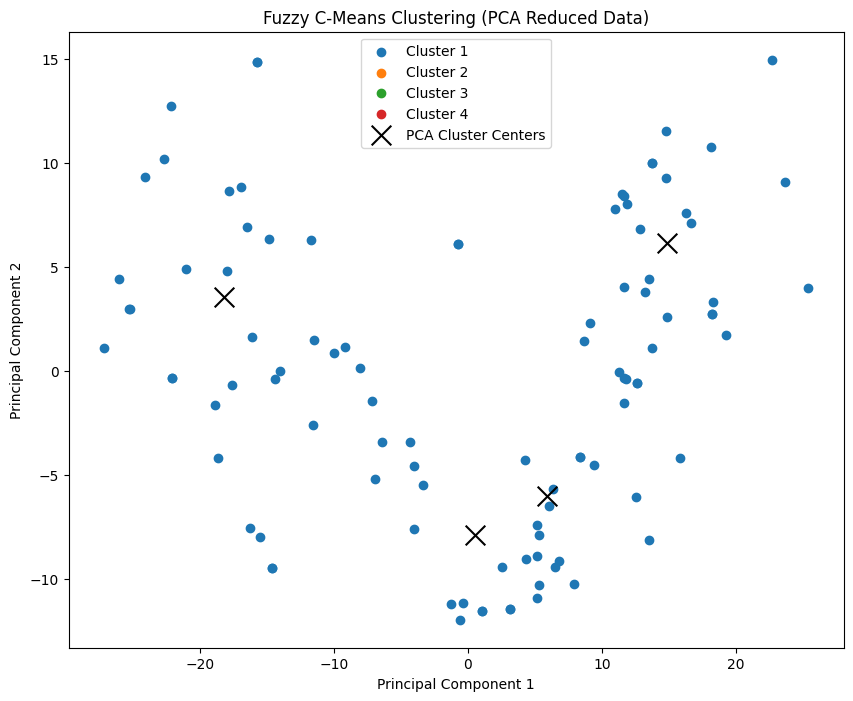

Silhouette Score: 0.16981171513888915
Davies-Bouldin Score: 1.7425806845444143
Rand Score: 0.5989242310577645
Tested fpc: 0.35684668944590303
Przetwarzamy chunk  2
p 3
fpc () 0.7371575329833889


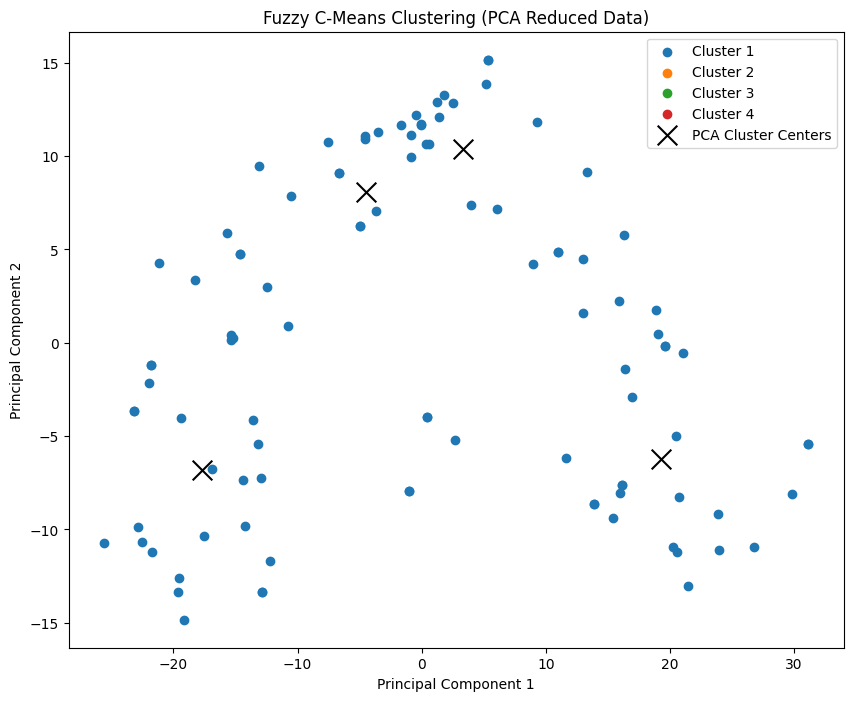

Silhouette Score: 0.23248736419634047
Davies-Bouldin Score: 1.7538923150396142
Rand Score: 0.6308635908977245
Tested fpc: 0.3601295659766652
Przetwarzamy chunk  3
p 8
fpc () 0.7481148919758738


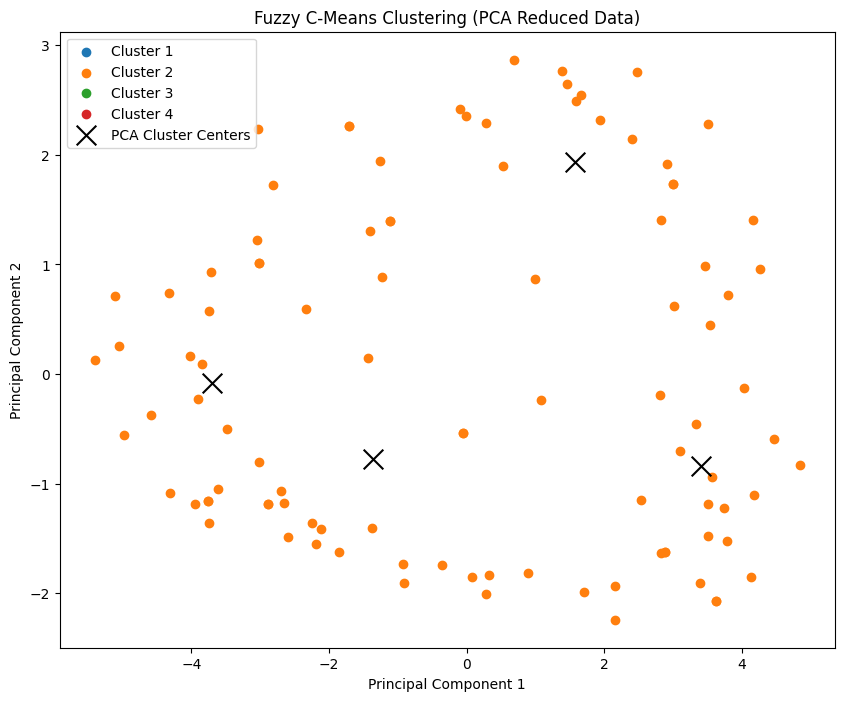

Silhouette Score: 0.11723211961236063
Davies-Bouldin Score: 1.9035842349060632
Rand Score: 0.6739138534633659
Tested fpc: 0.34935426091599503
Przetwarzamy chunk  4
p 4
fpc () 0.7333358973594136


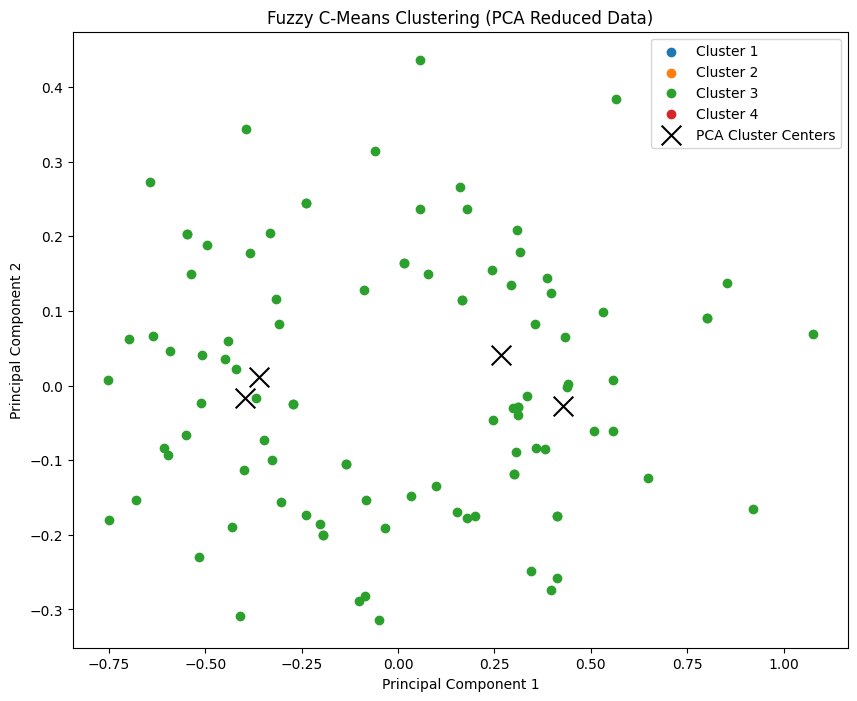

Silhouette Score: -0.18022483289555793
Davies-Bouldin Score: 3.5632705235602504
Rand Score: 0.594998624656164
Tested fpc: 0.2735584814762848
Przetwarzamy chunk  5
p 2
fpc () 0.7298315264967755


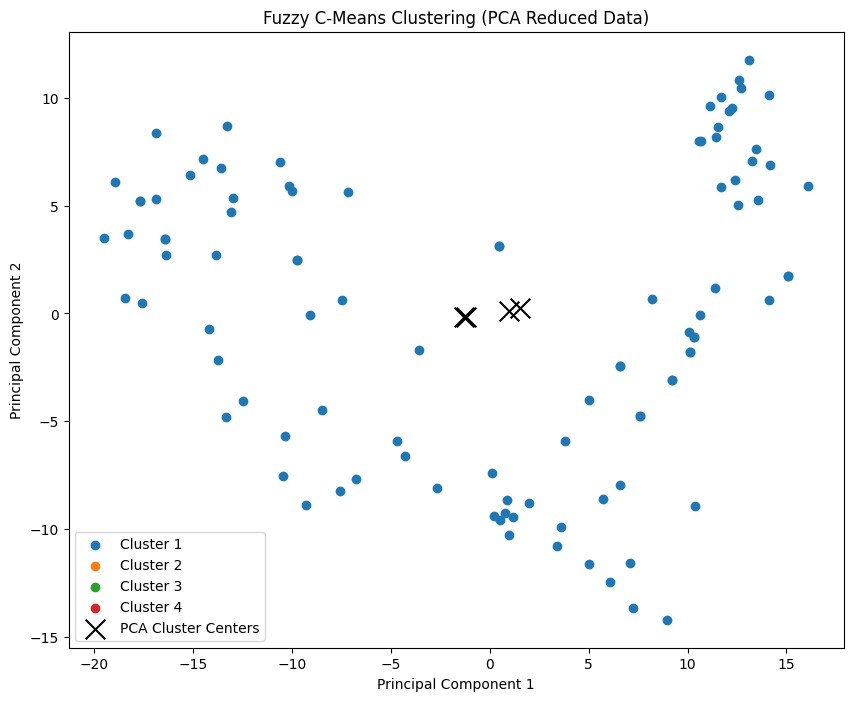

Silhouette Score: -0.0965672736642431
Davies-Bouldin Score: 2.9496802215252838
Rand Score: 0.6676302825706426
Tested fpc: 0.25499349871949195
Przetwarzamy chunk  6
p 3
fpc () 0.72591221644917


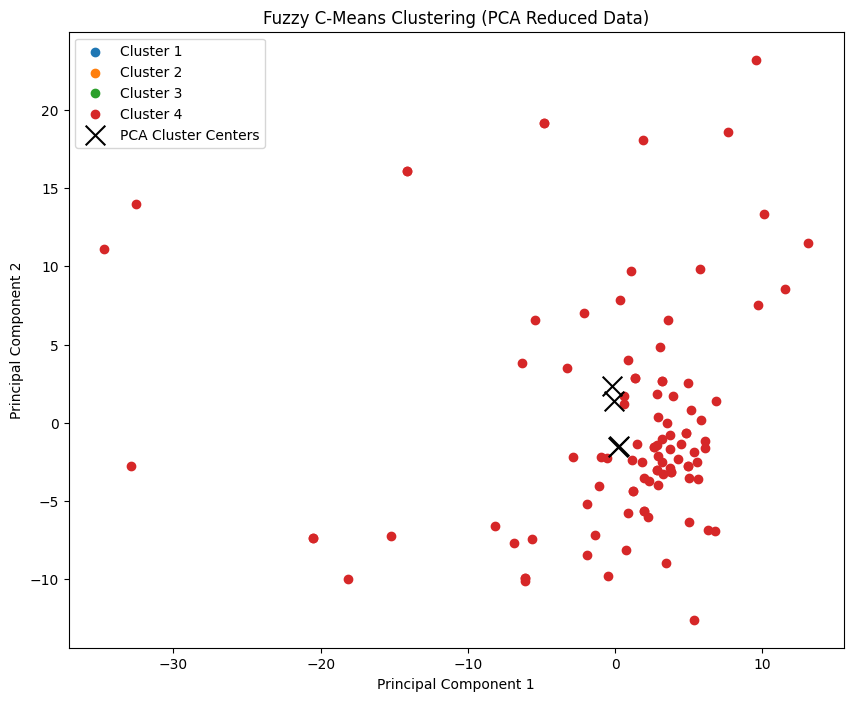

Silhouette Score: 0.1564357439525907
Davies-Bouldin Score: 1.9215330667373673
Rand Score: 0.6943865966491622
Tested fpc: 0.26665101687057696
Przetwarzamy chunk  7
p 11
fpc () 0.7415362030059005


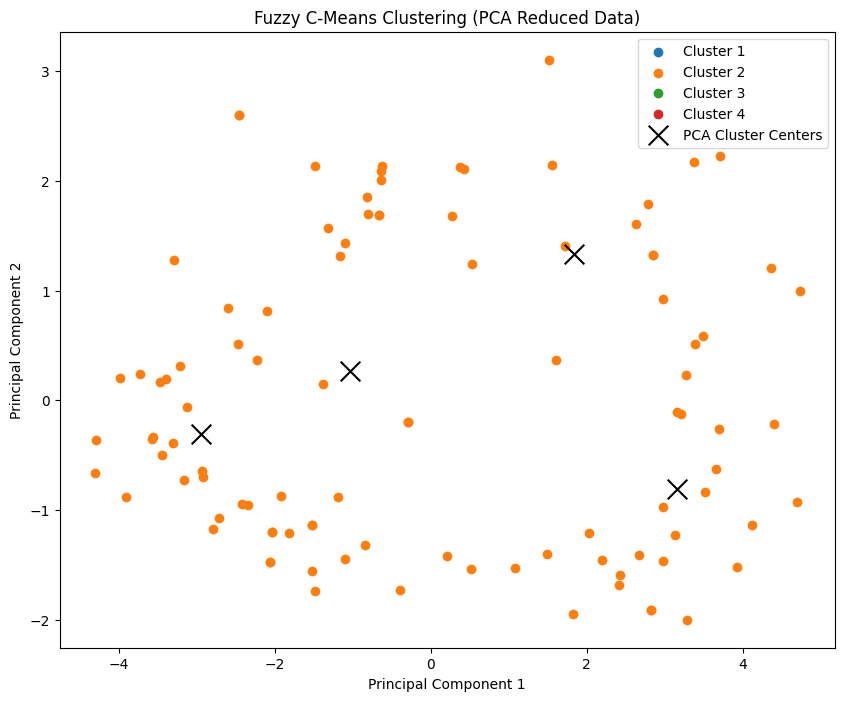

Silhouette Score: 0.08576100214113802
Davies-Bouldin Score: 2.4753636019862113
Rand Score: 0.646764816204051
Tested fpc: 0.3331735782556379
Przetwarzamy chunk  8
p 8
fpc () 0.7164264881931522


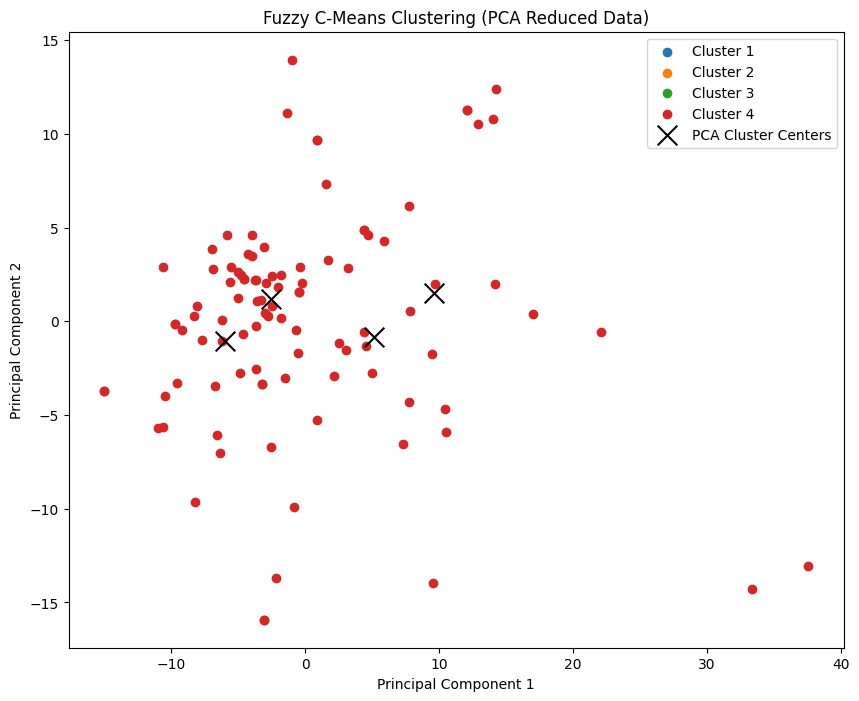

Silhouette Score: 0.26989199717307805
Davies-Bouldin Score: 1.3329918628879682
Rand Score: 0.6371194048512128
Tested fpc: 0.4059459000952056
Przetwarzamy chunk  9
p 11
fpc () 0.814436036059415


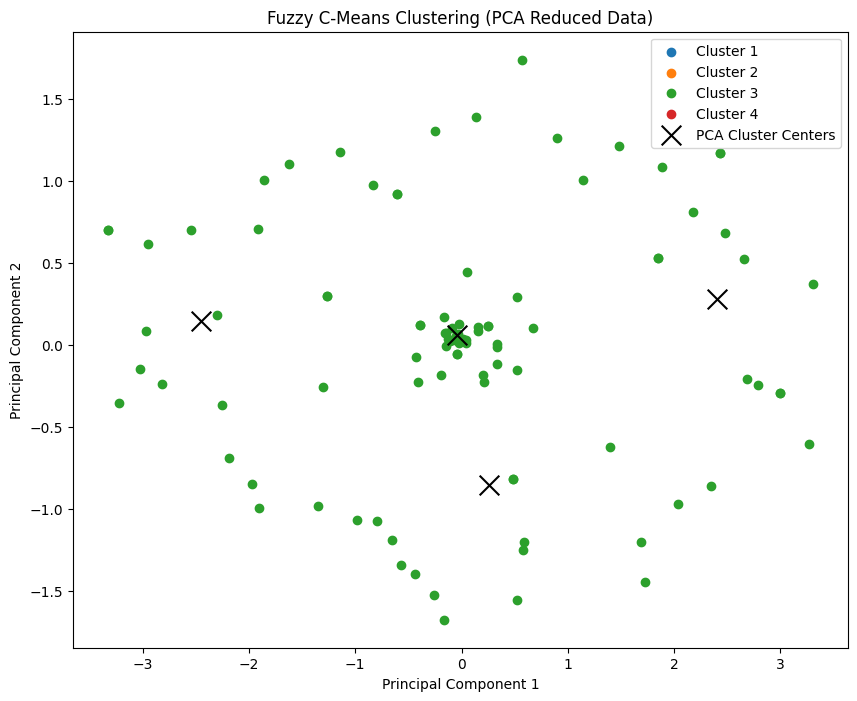

Silhouette Score: 0.006109955380564682
Davies-Bouldin Score: 2.1597928184537882
Rand Score: 0.6788300825206302
Tested fpc: 0.3735068315899682
Przetwarzamy chunk  10
p 6
fpc () 0.7452776673668527


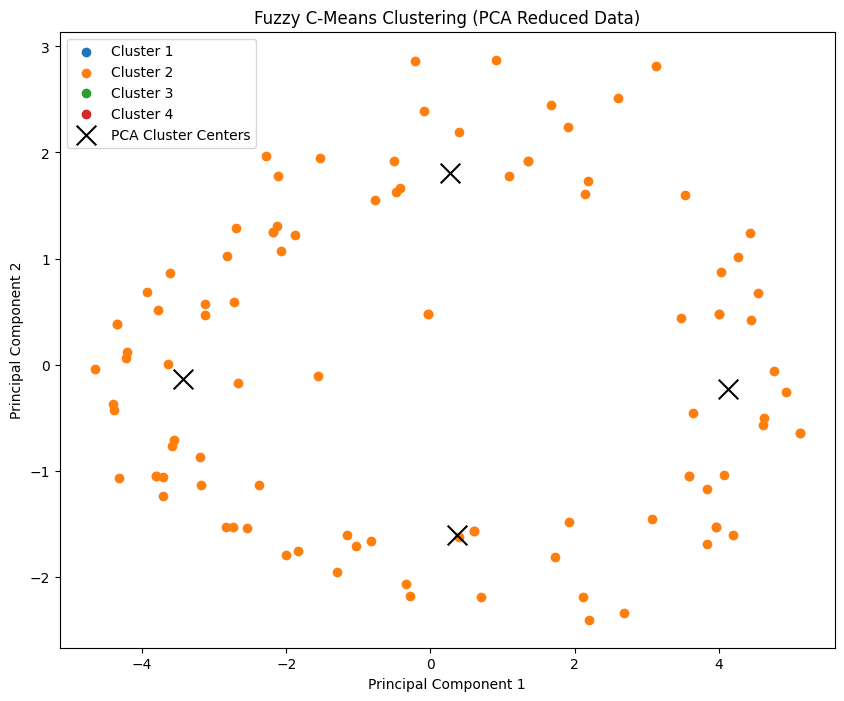

Silhouette Score: 0.06299702872560016
Davies-Bouldin Score: 2.2298349146666605
Rand Score: 0.6511702925731433
Tested fpc: 0.33802424974254786
Przetwarzamy chunk  11
p 9
fpc () 0.766195263799746


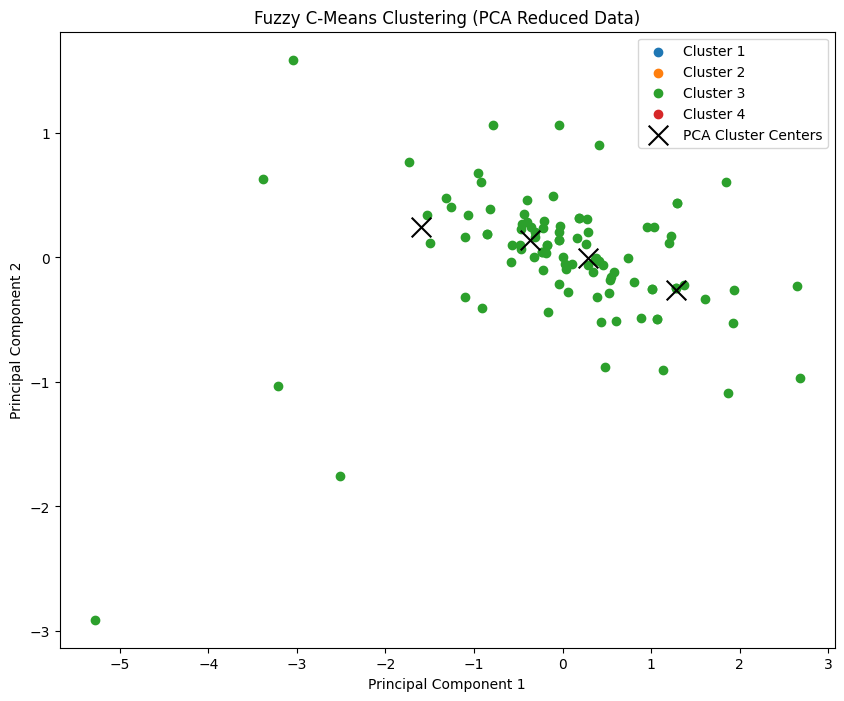

Silhouette Score: -0.18902331729347055
Davies-Bouldin Score: 2.545721734652739
Rand Score: 0.6448244561140285
Tested fpc: 0.3259314373000316
Przetwarzamy chunk  12
p 12
fpc () 0.7504055794722695


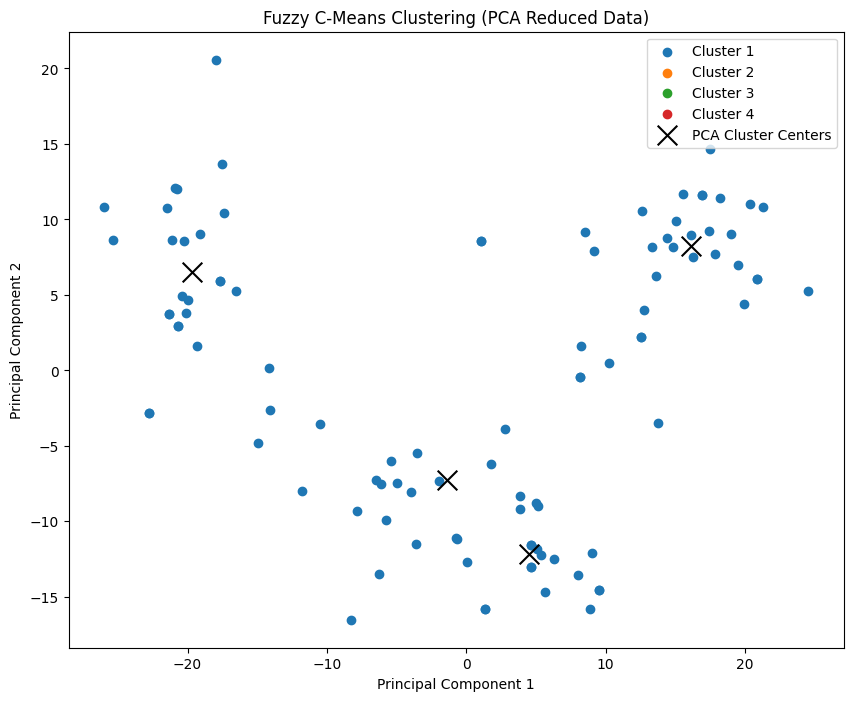

Silhouette Score: 0.20775610193129054
Davies-Bouldin Score: 1.6333464646825027
Rand Score: 0.5928002000500125
Tested fpc: 0.3632731786392967
Przetwarzamy chunk  13
p 13
fpc () 0.7534643780941159


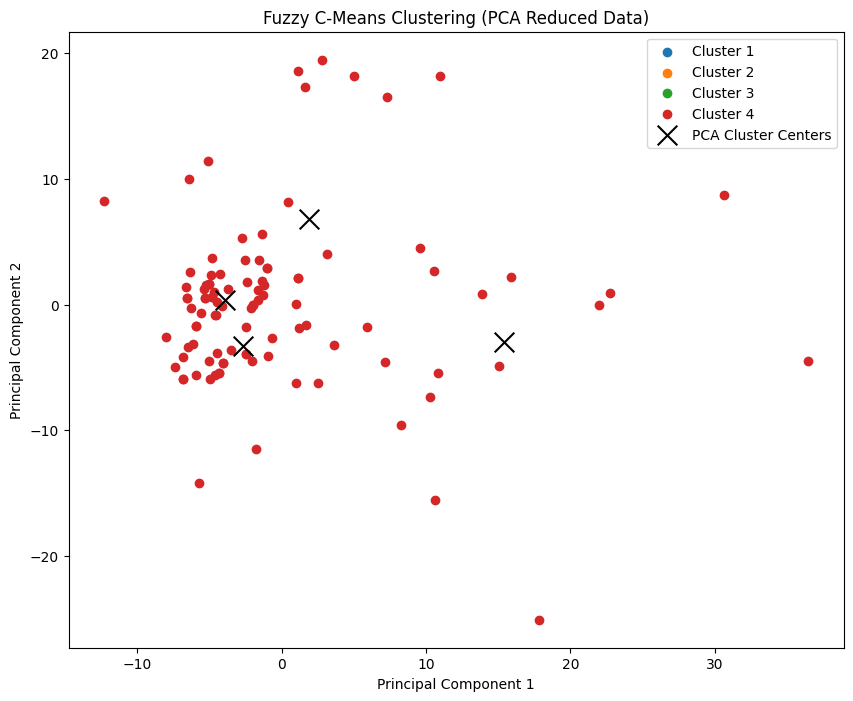

Silhouette Score: 0.36583095225609863
Davies-Bouldin Score: 1.3735634618959354
Rand Score: 0.6114046011502876
Tested fpc: 0.4810032713482332
Przetwarzamy chunk  14
p 5
fpc () 0.7667217370950784


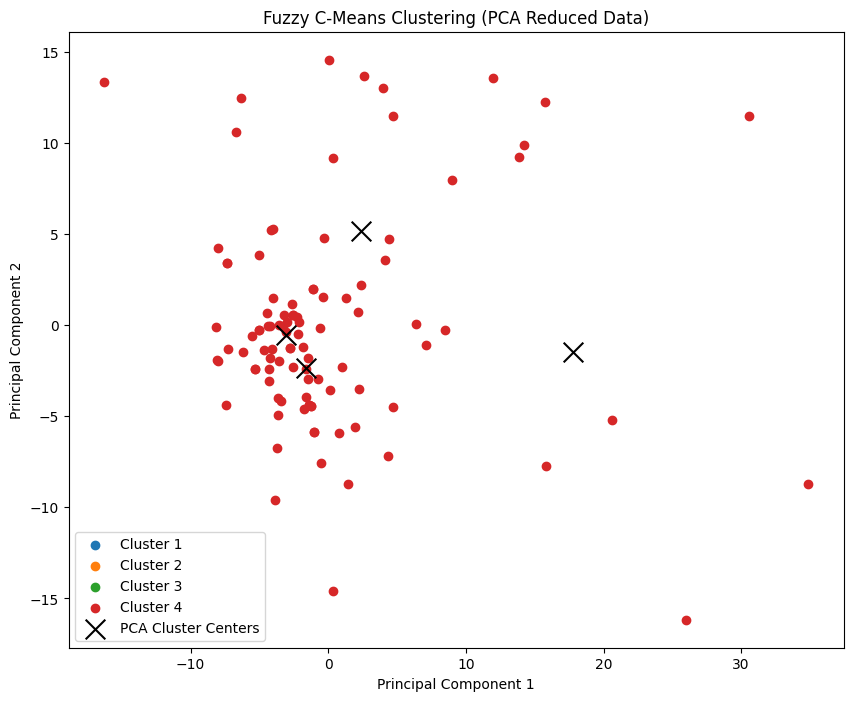

Silhouette Score: 0.2833924828510012
Davies-Bouldin Score: 1.3987279818512044
Rand Score: 0.6542835708927232
Tested fpc: 0.4786280194370862
Przetwarzamy chunk  15
p 9
fpc () 0.774881232255105


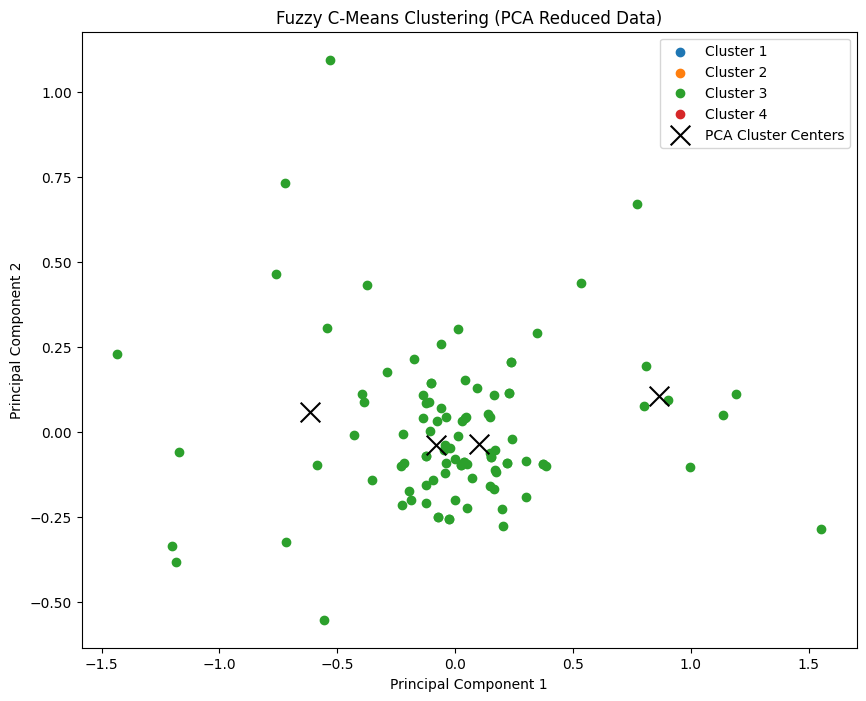

Silhouette Score: -0.2686033238932923
Davies-Bouldin Score: 2.1114932371846225
Rand Score: 0.5893017004251063
Tested fpc: 0.2898450622674155
Przetwarzamy chunk  16
p 12
fpc () 0.7365451788131422


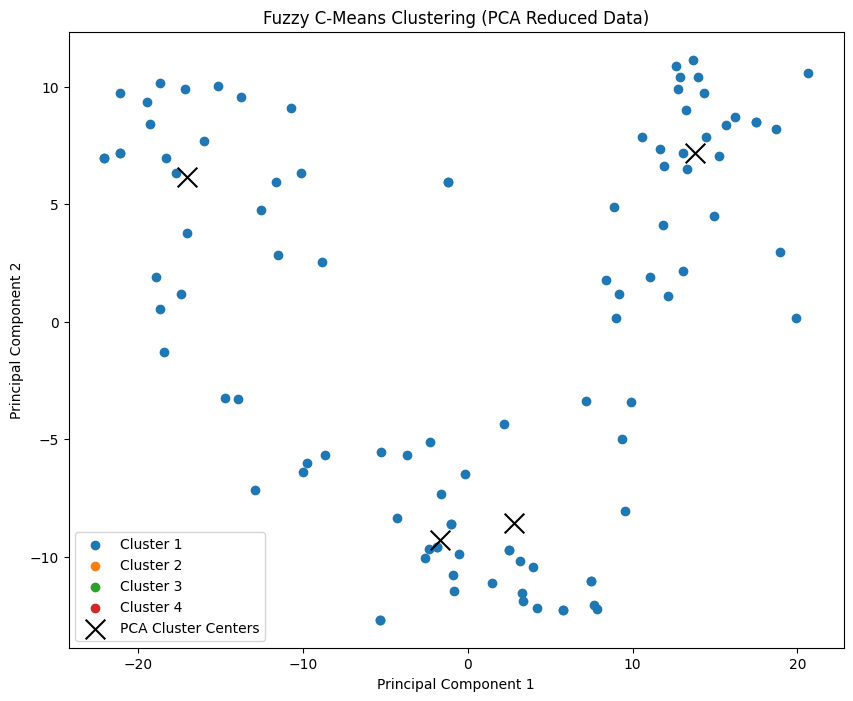

Silhouette Score: 0.18371603778676904
Davies-Bouldin Score: 1.5782404601768547
Rand Score: 0.5806790447611903
Tested fpc: 0.3632703971363061
Przetwarzamy chunk  17
p 9
fpc () 0.7386678309045311


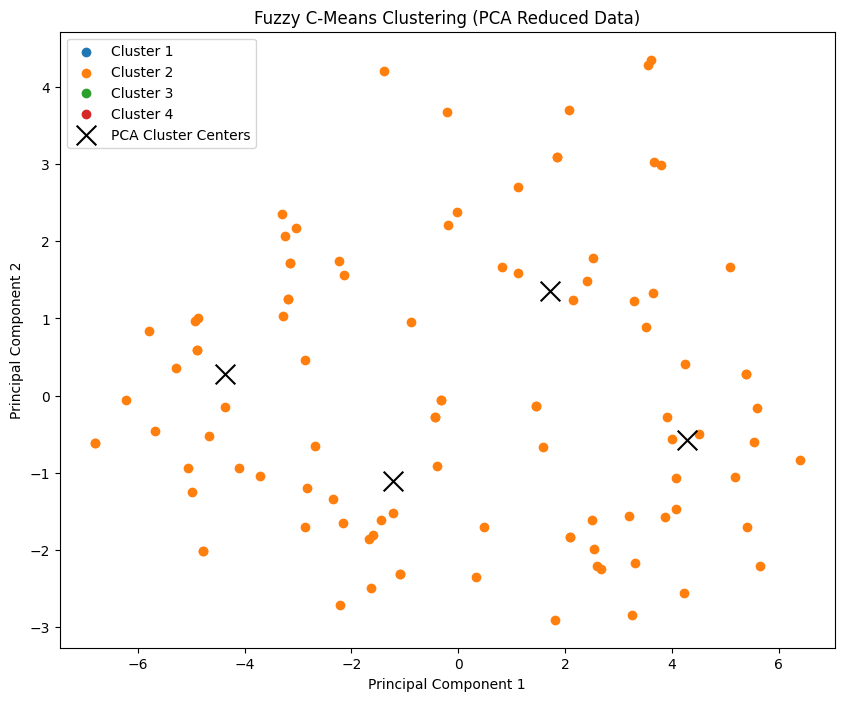

Silhouette Score: 0.12734400611794378
Davies-Bouldin Score: 2.0651901212338677
Rand Score: 0.6734694923730933
Tested fpc: 0.35620844635417337
Przetwarzamy chunk  18
p 7
fpc () 0.7758307745536515


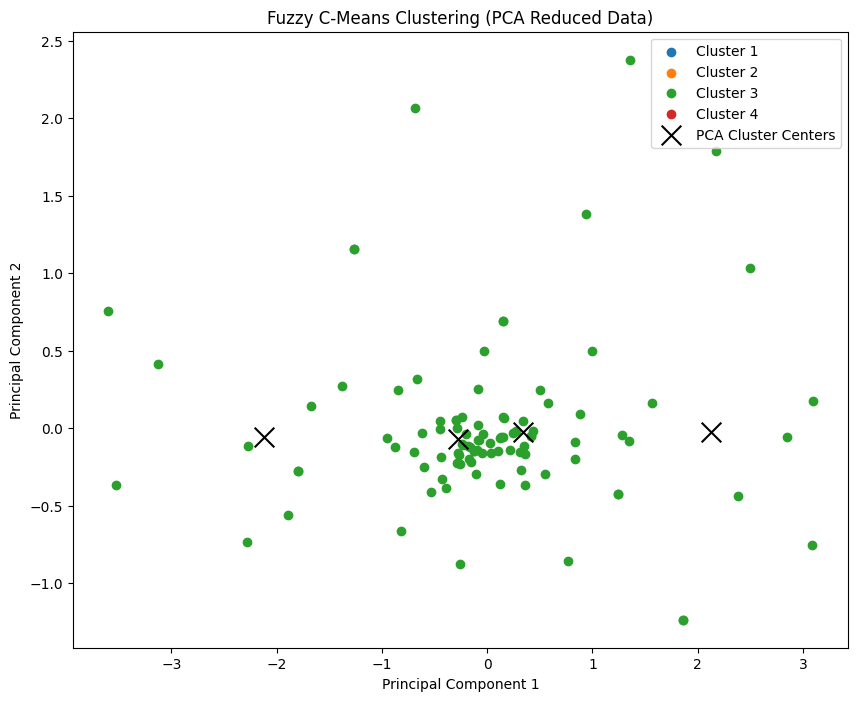

Silhouette Score: -0.14807847274542768
Davies-Bouldin Score: 2.2571334261213907
Rand Score: 0.6606549137284321
Tested fpc: 0.3504377808379126
Przetwarzamy chunk  19
p 3
fpc () 0.7295304148998377


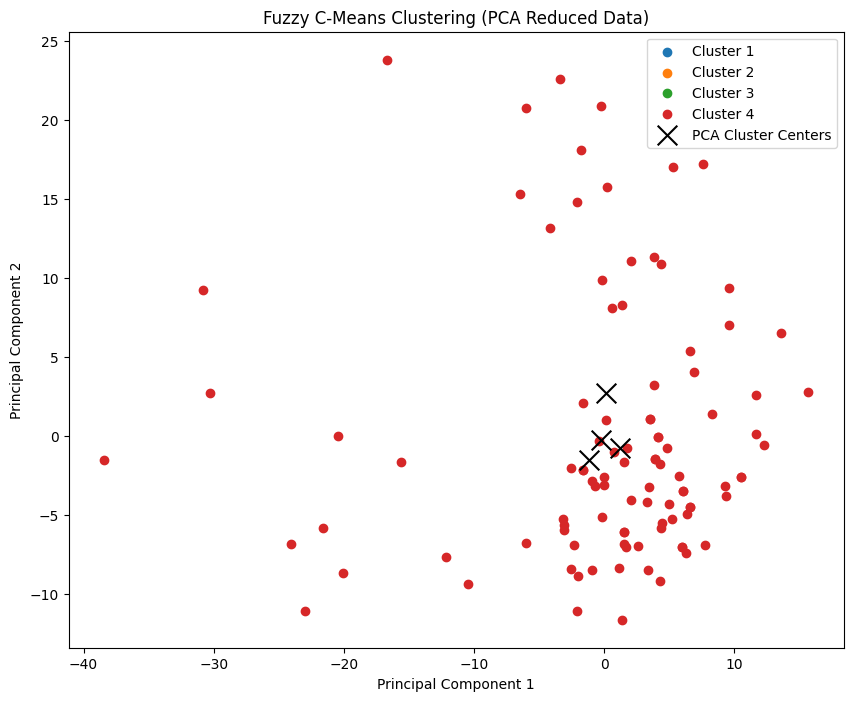

Silhouette Score: 0.3489996438012145
Davies-Bouldin Score: 1.6004274852474674
Rand Score: 0.5766539134783696
Tested fpc: 0.2649485595574532
Przetwarzamy chunk  20
p 2
fpc () 0.7302947954624892


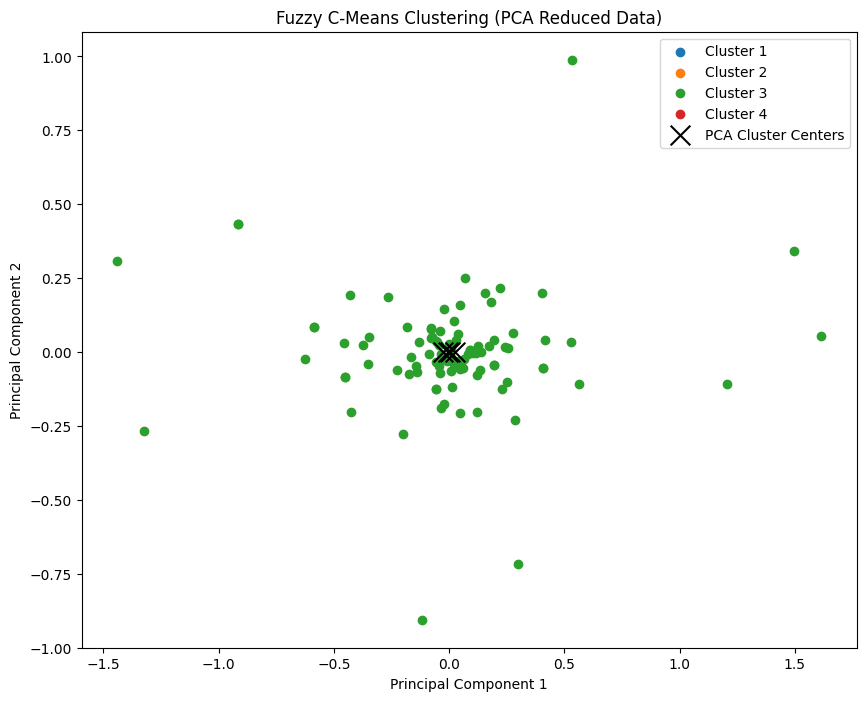

Silhouette Score: -0.4316904727226557
Davies-Bouldin Score: 2.402286453728694
Rand Score: 0.5084398599649913
Tested fpc: 0.250313125648791
Przetwarzamy chunk  21
p 2
fpc () 0.73000150378234


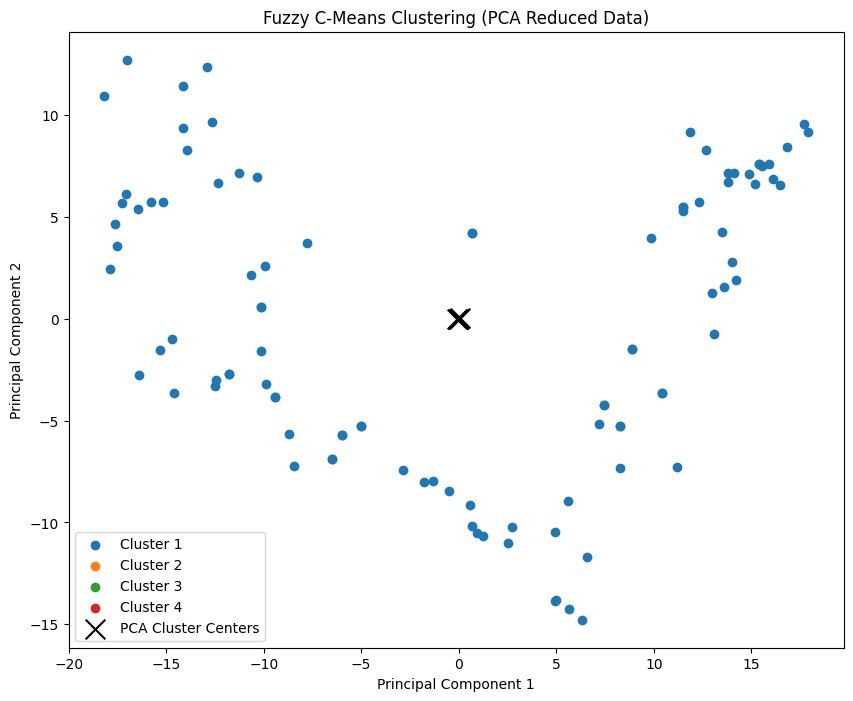

Silhouette Score: -0.3727342174850323
Davies-Bouldin Score: 1.7442875730703369
Rand Score: 0.4954176044011003
Tested fpc: 0.2500122405978977
Przetwarzamy chunk  22
p 2
fpc () 0.730018597187335


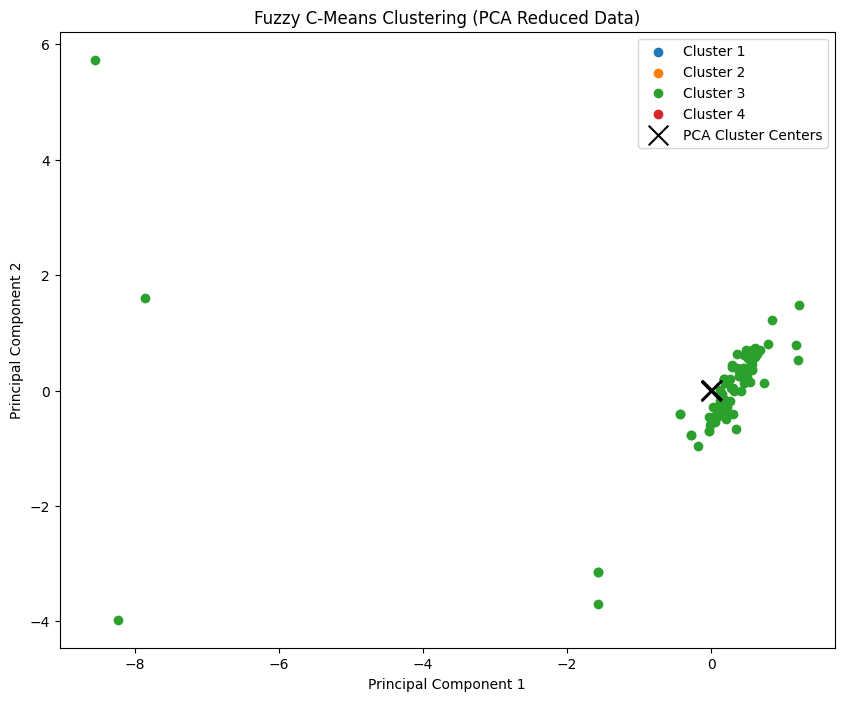

Silhouette Score: -0.4320563104329567
Davies-Bouldin Score: 2.0820908924254438
Rand Score: 0.5159569892473118
Tested fpc: 0.25006346321833983
Przetwarzamy chunk  23
p 2
fpc () 0.7298243943049699


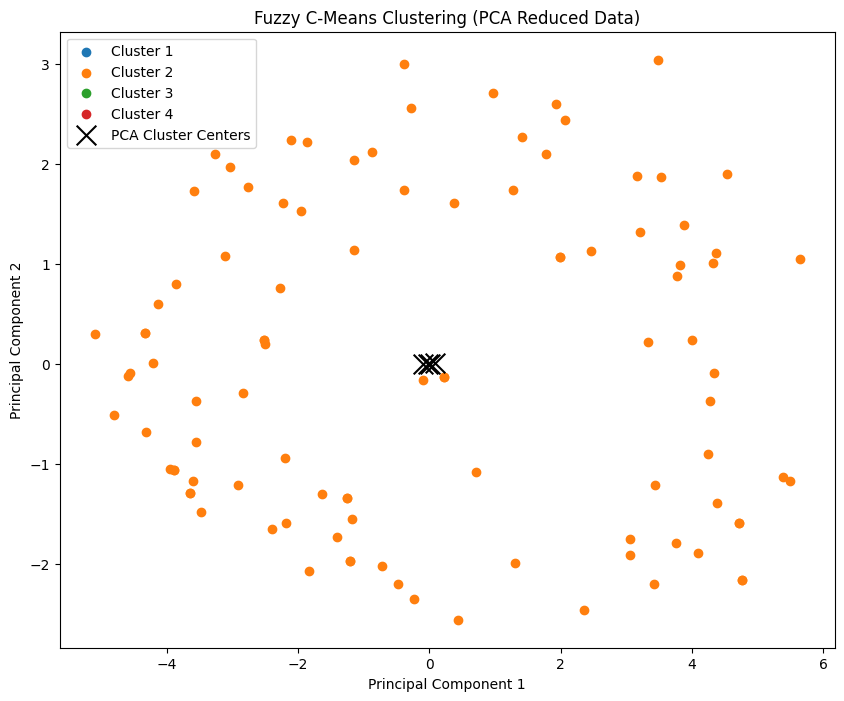

Silhouette Score: -0.3048140098580394
Davies-Bouldin Score: 4.842385408728089
Rand Score: 0.5032189297324331
Tested fpc: 0.2501943592318349
Przetwarzamy chunk  24
p 2
fpc () 0.7290051064156748


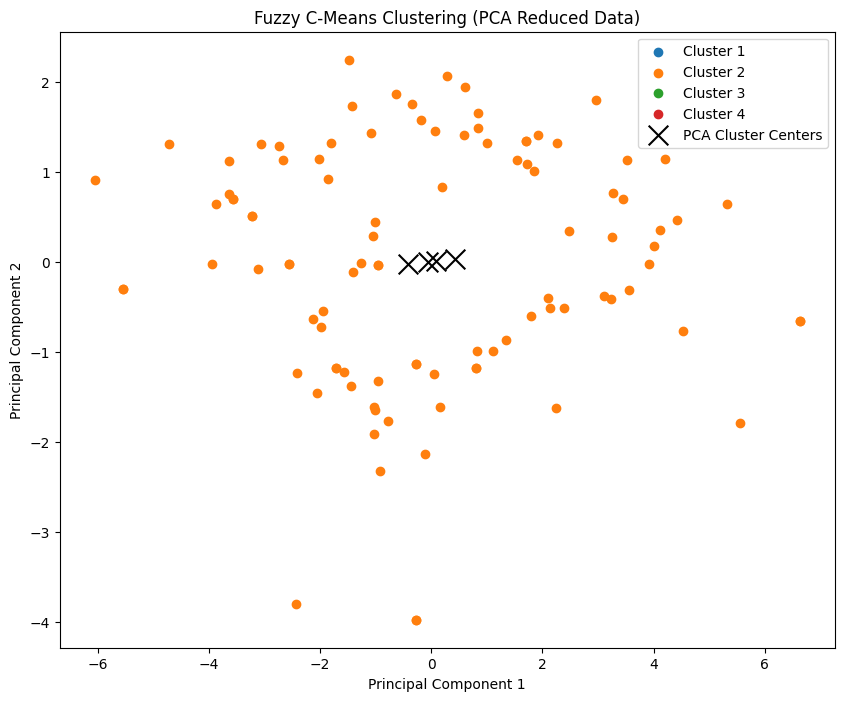

Silhouette Score: -0.281685673401058
Davies-Bouldin Score: 4.992745309106838
Rand Score: 0.5499216054013504
Tested fpc: 0.25495409004593184
Przetwarzamy chunk  25
p 7
fpc () 0.7331663232872154


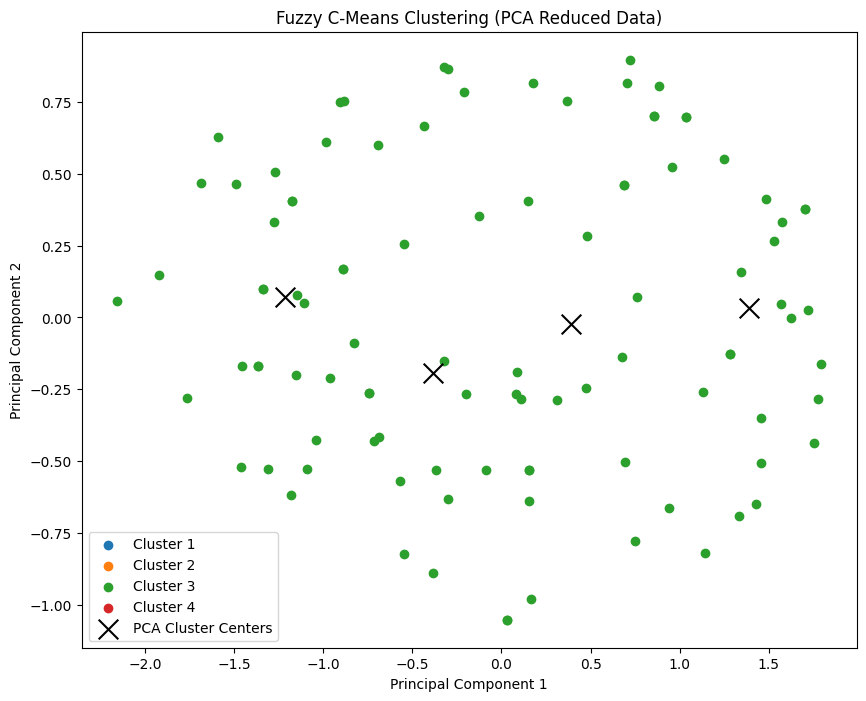

Silhouette Score: -0.1801830633323983
Davies-Bouldin Score: 2.4302564797978476
Rand Score: 0.6363347086771693
Tested fpc: 0.3121231951170122
Przetwarzamy chunk  26
p 3
fpc () 0.7359921870326663


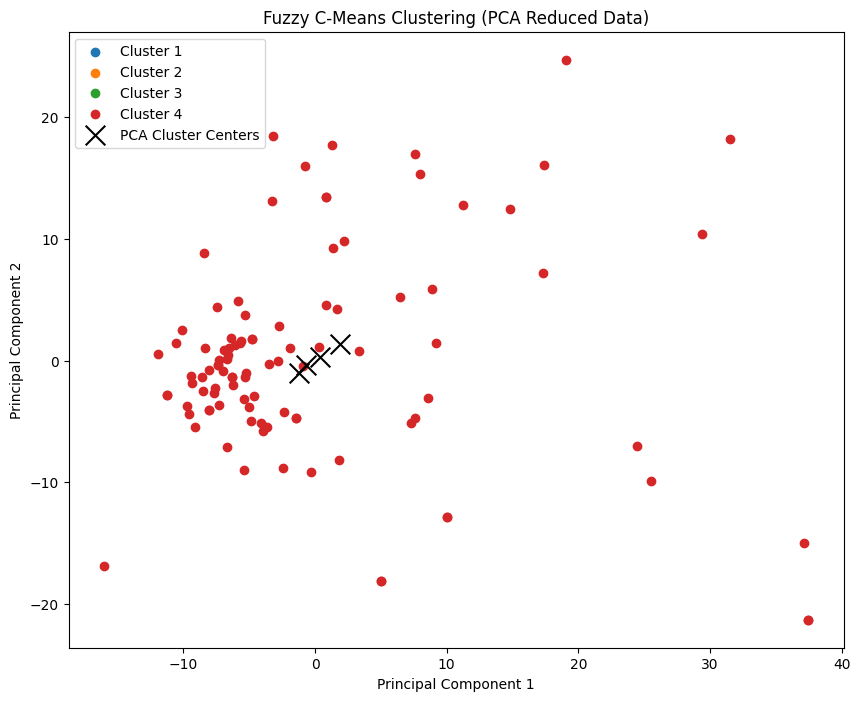

Silhouette Score: 0.1292294917084436
Davies-Bouldin Score: 2.2938707451452207
Rand Score: 0.47954276069017254
Tested fpc: 0.26402819514231723
Przetwarzamy chunk  27
p 8
fpc () 0.7672649096718185


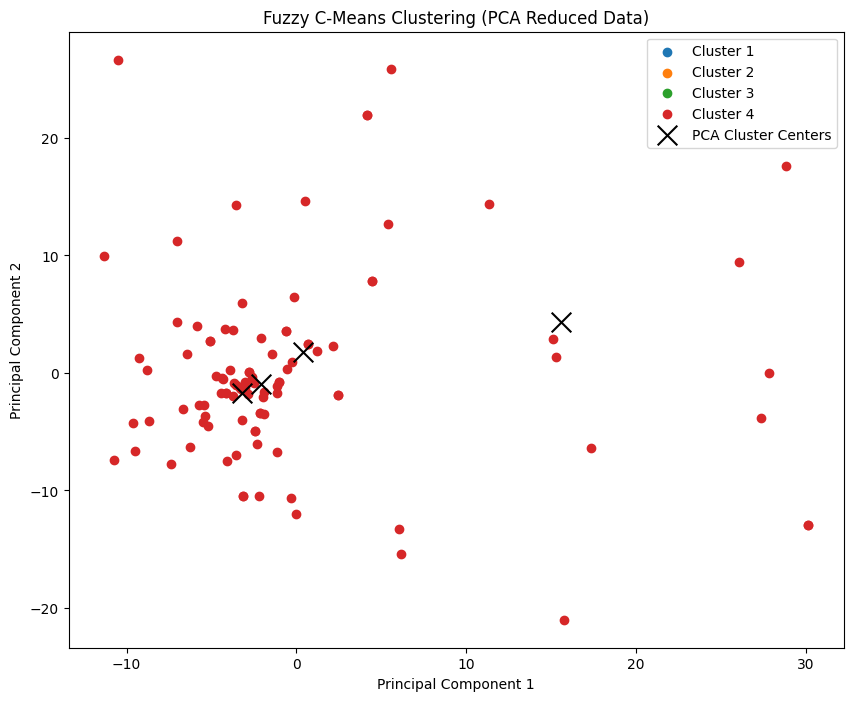

Silhouette Score: 0.18973444092217756
Davies-Bouldin Score: 2.254591561665193
Rand Score: 0.5556217804451112
Tested fpc: 0.36121086923181883
Przetwarzamy chunk  28
p 12
fpc () 0.38208465944285697


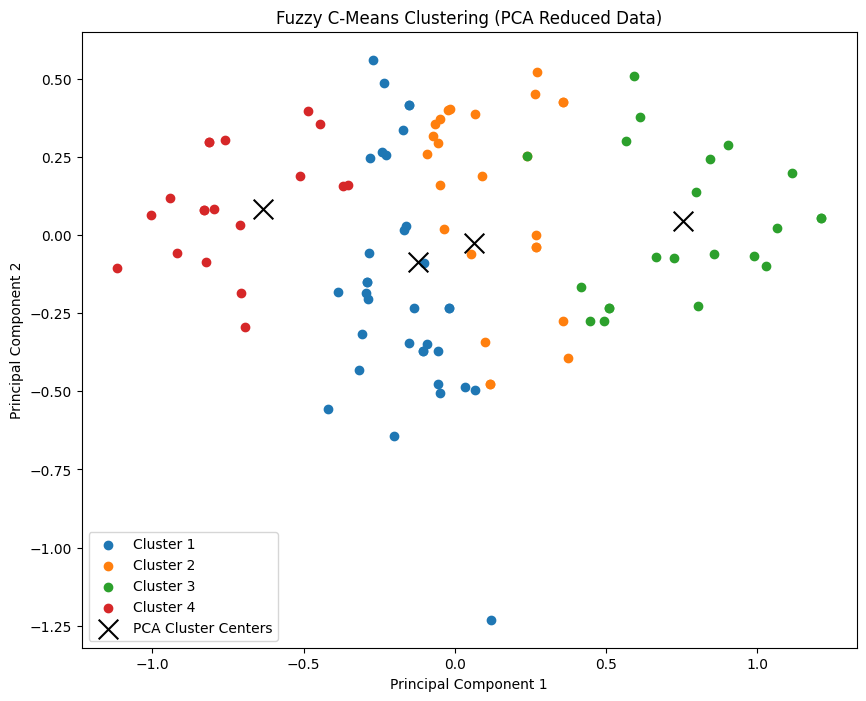

Silhouette Score: -0.2684827340407811
Davies-Bouldin Score: 2.1474889341327565
Rand Score: 0.5936901725431358
Tested fpc: 0.2844659921454148
Przetwarzamy chunk  29
p 24
fpc () 0.44115546609776257


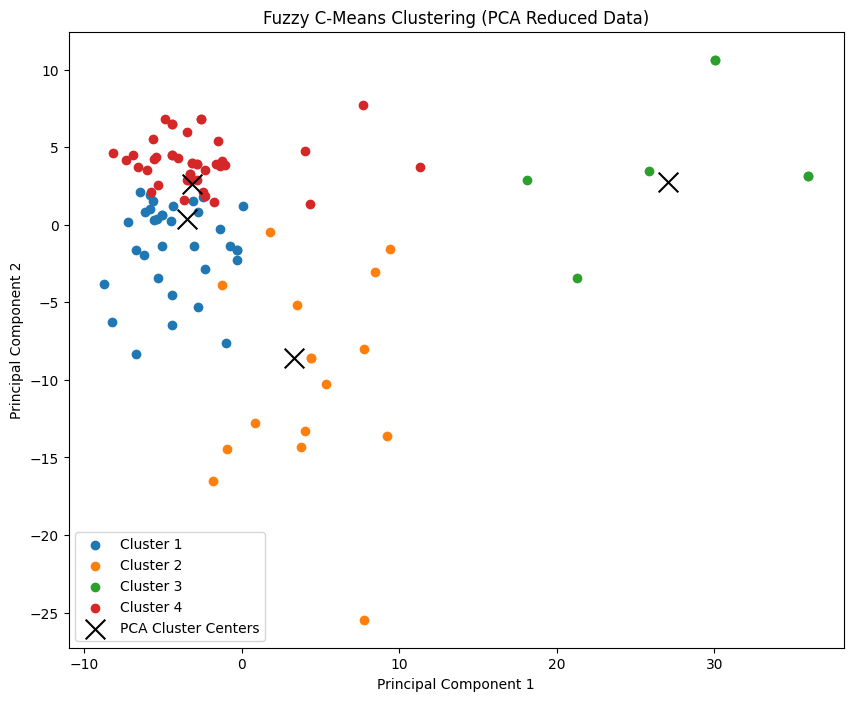

Silhouette Score: 0.20278902872644572
Davies-Bouldin Score: 1.4422186007432694
Rand Score: 0.6123377094273569
Tested fpc: 0.4387652105826228
Przetwarzamy chunk  30
p 10
fpc () 0.4979397711233385


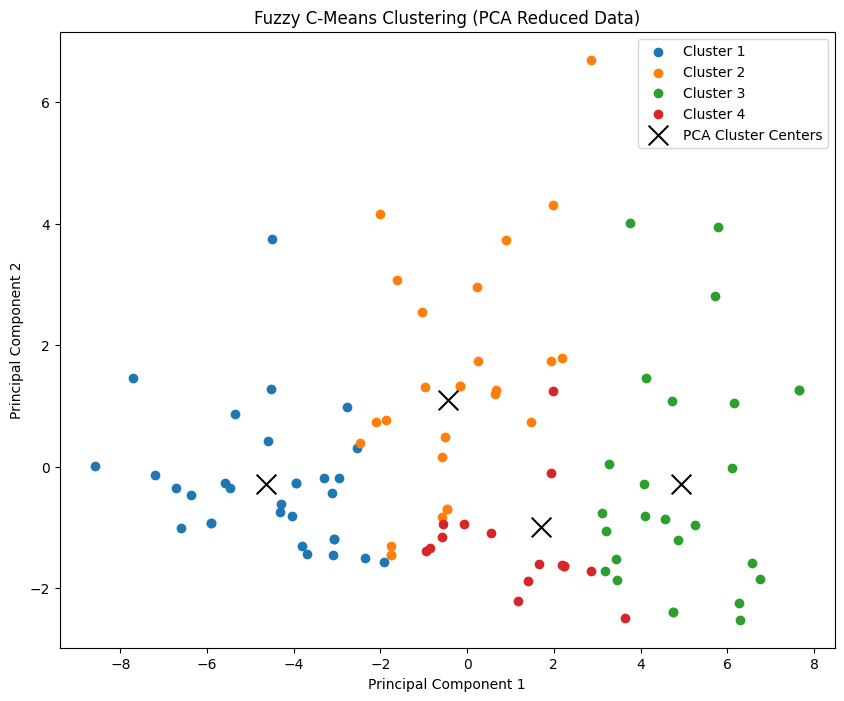

Silhouette Score: 0.020661932277780366
Davies-Bouldin Score: 2.180264219480569
Rand Score: 0.651078144536134
Tested fpc: 0.3605883728348855
Przetwarzamy chunk  31
p 48
fpc () 0.41998499672008494


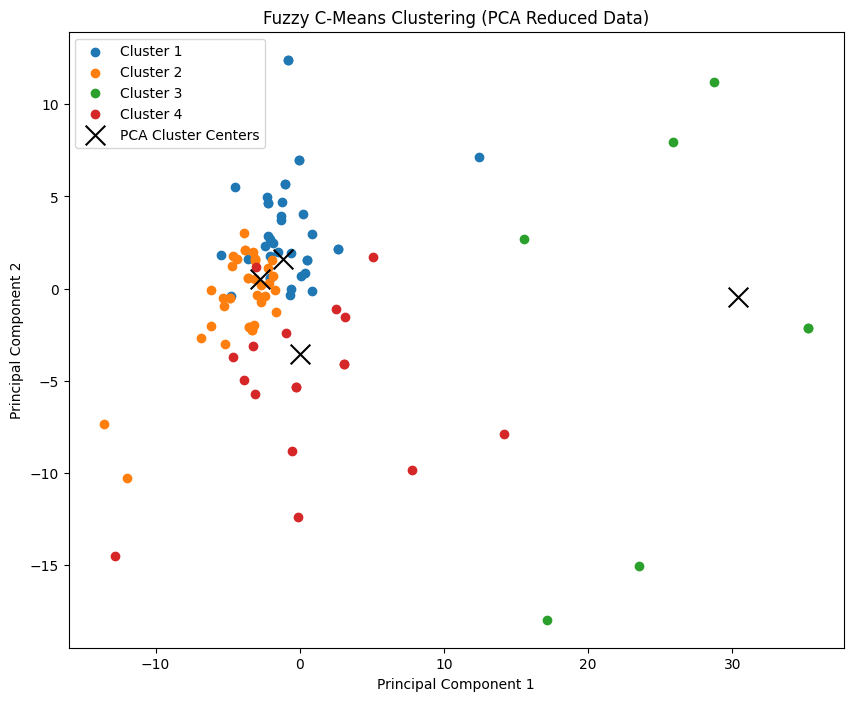

Silhouette Score: 0.2248083926780734
Davies-Bouldin Score: 1.716423121752463
Rand Score: 0.618797824456114
Tested fpc: 0.41857085377955194
Przetwarzamy chunk  32
p 18
fpc () 0.6624751426227019


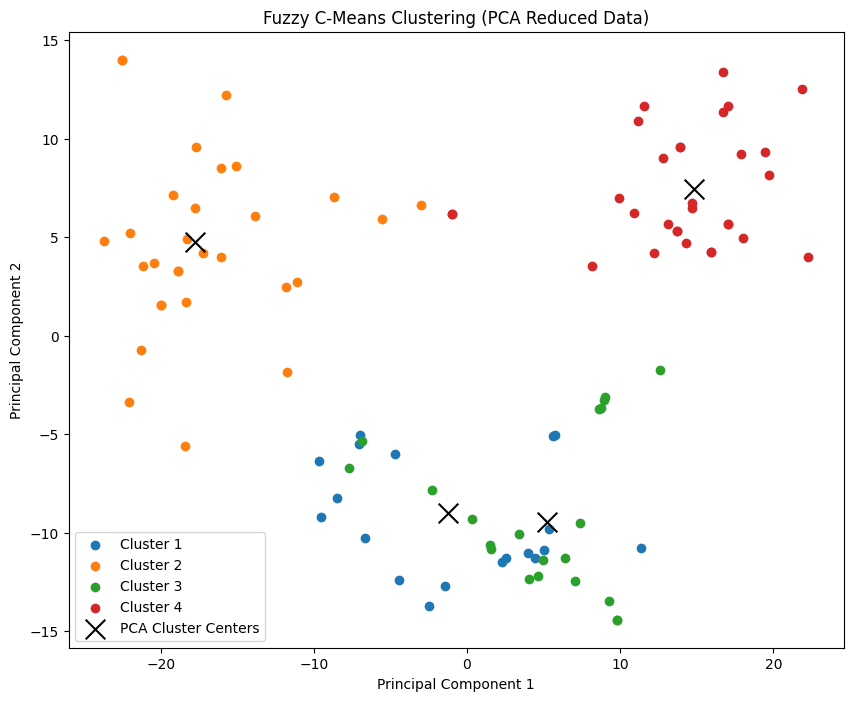

Silhouette Score: 0.10106497977383401
Davies-Bouldin Score: 1.7720510148739284
Rand Score: 0.61739759939985
Tested fpc: 0.36479644942901185
Przetwarzamy chunk  33
p 12
fpc () 0.4976210883708179


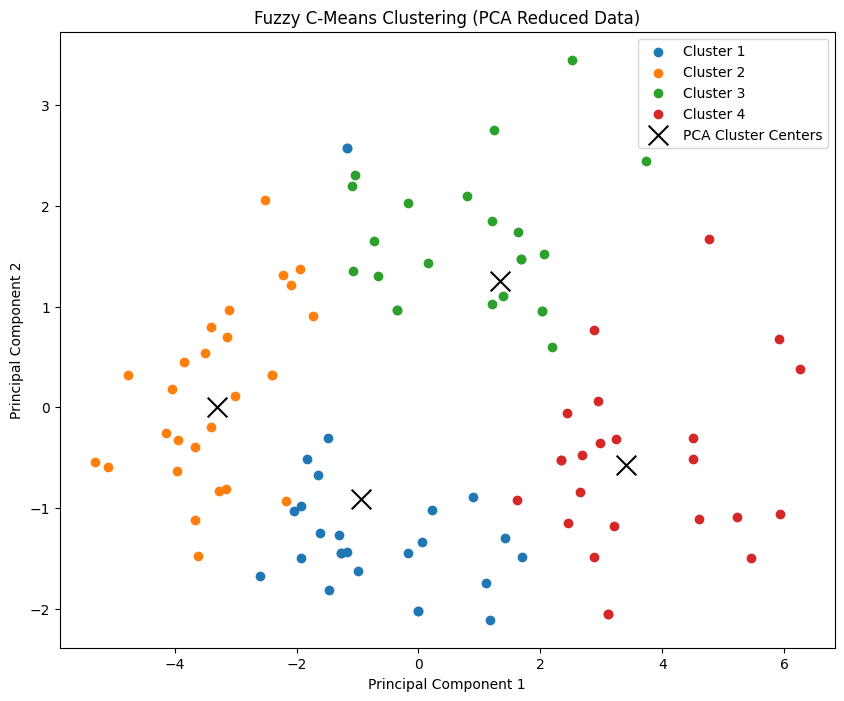

Silhouette Score: 0.05696724987558298
Davies-Bouldin Score: 2.010384351319457
Rand Score: 0.671464241060265
Tested fpc: 0.3533231322801099
Przetwarzamy chunk  34
p 10
fpc () 0.6591463325554483


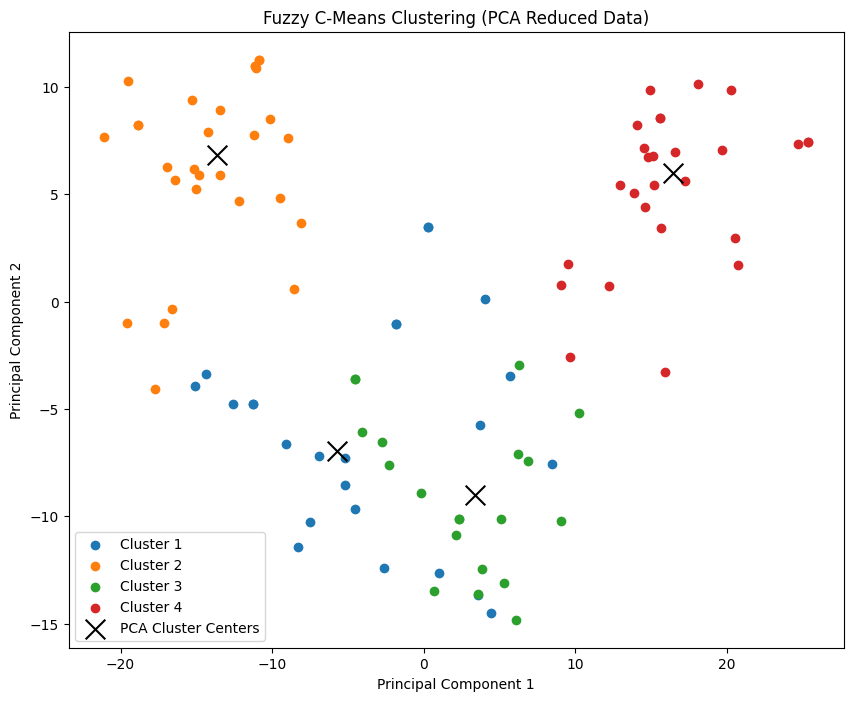

Silhouette Score: 0.08738657718571713
Davies-Bouldin Score: 1.876438369476371
Rand Score: 0.6569323580895223
Tested fpc: 0.35639275053670066
Przetwarzamy chunk  35
p 15
fpc () 0.5548950596185387


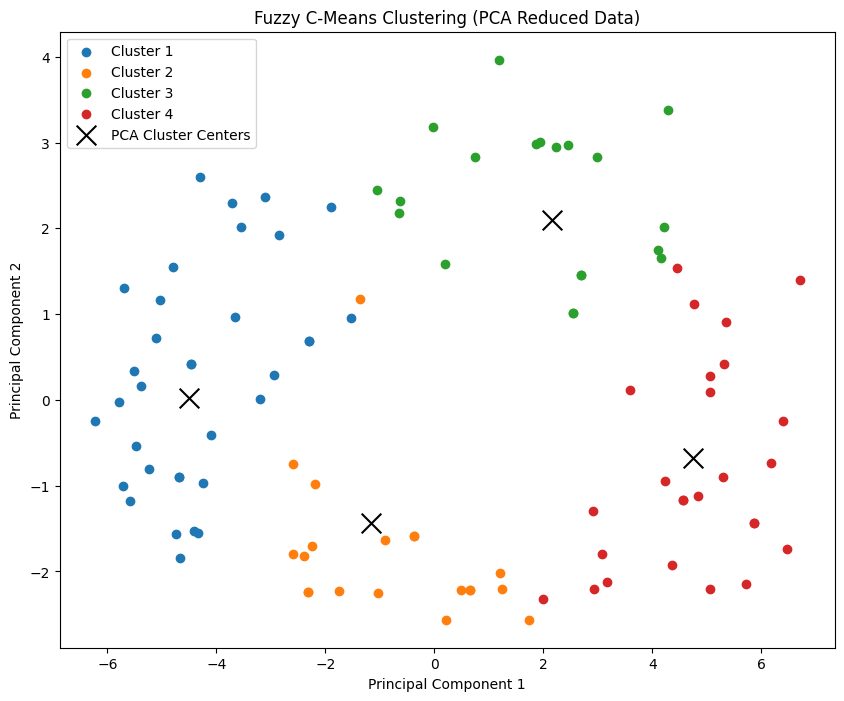

Silhouette Score: 0.1387896502158154
Davies-Bouldin Score: 1.859209640829337
Rand Score: 0.6727228057014254
Tested fpc: 0.3577546840792612
Przetwarzamy chunk  36
p 8
fpc () 0.6116380498688497


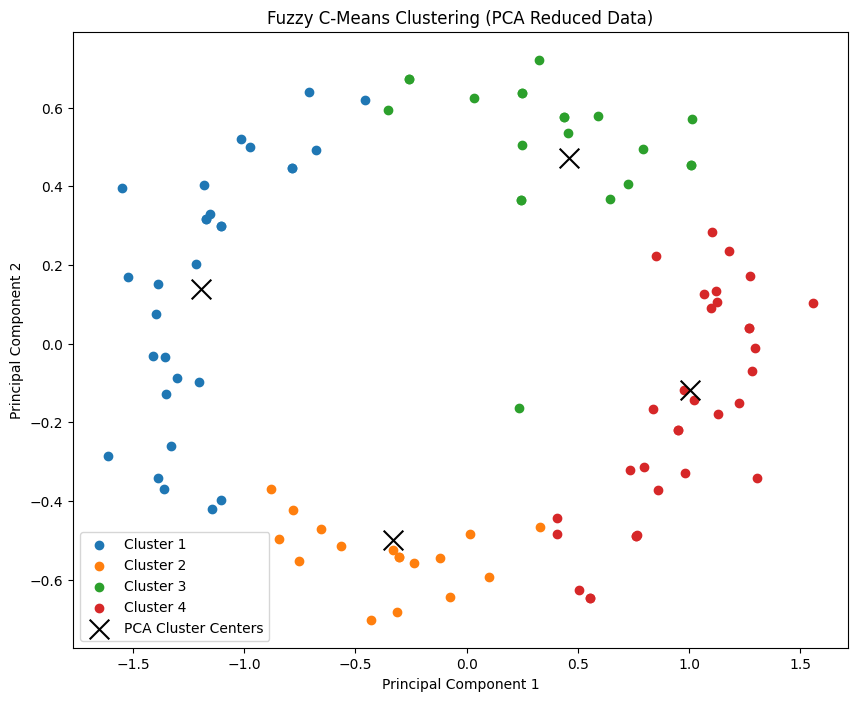

Silhouette Score: -0.11640469047602628
Davies-Bouldin Score: 2.203347083096088
Rand Score: 0.6258175793948487
Tested fpc: 0.3021418937419585
Przetwarzamy chunk  37
p 13
fpc () 0.6723482357664227


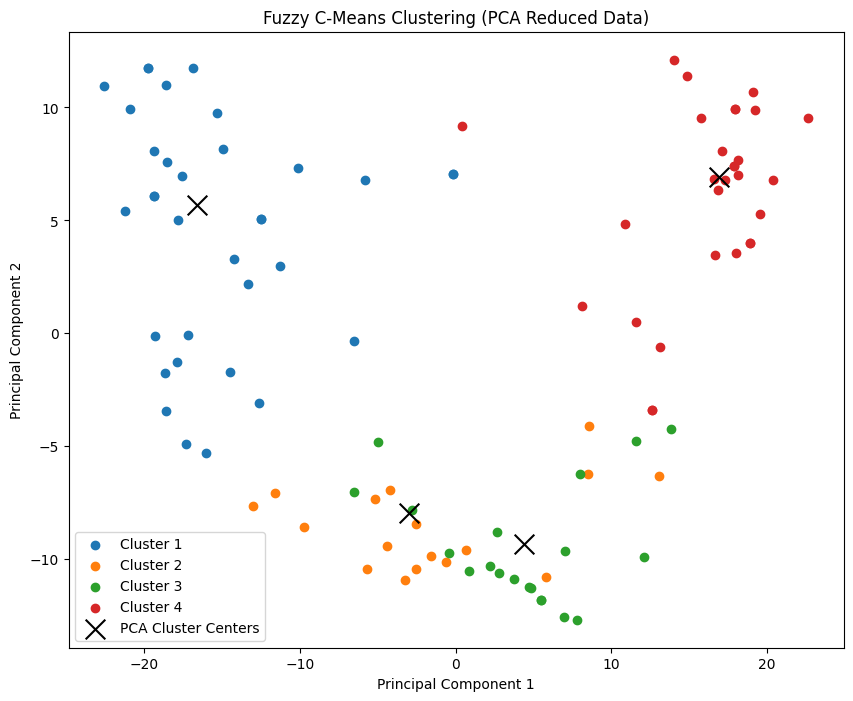

Silhouette Score: 0.2730393700304193
Davies-Bouldin Score: 1.5411191338541048
Rand Score: 0.6089364841210303
Tested fpc: 0.3666468748139598
Przetwarzamy chunk  38
p 15
fpc () 0.5391711407514193


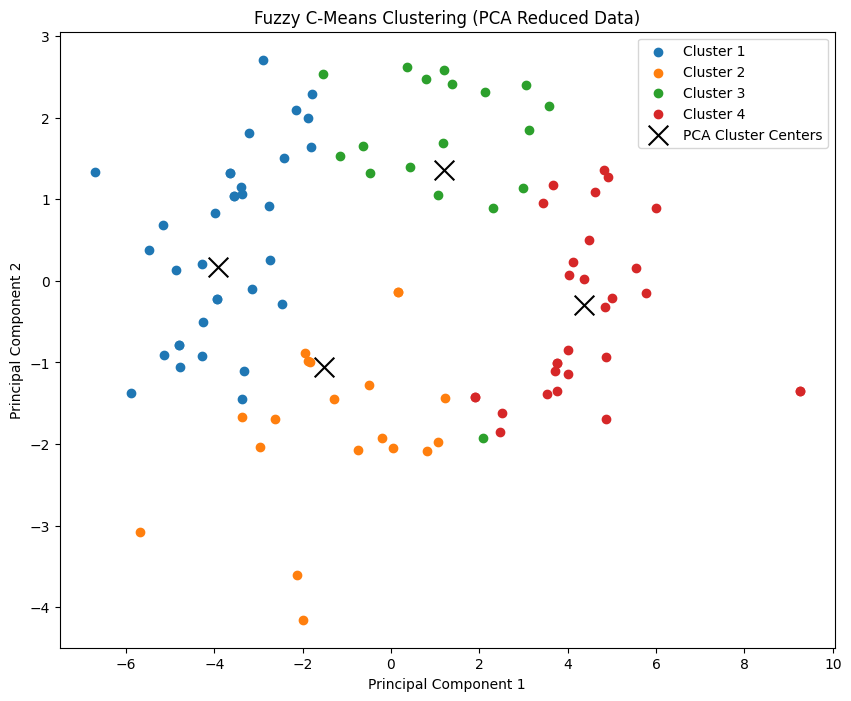

Silhouette Score: 0.03075028367508242
Davies-Bouldin Score: 2.196231782582968
Rand Score: 0.6674096024006001
Tested fpc: 0.34821154817848804
Przetwarzamy chunk  39
p 36
fpc () 0.522881349675597


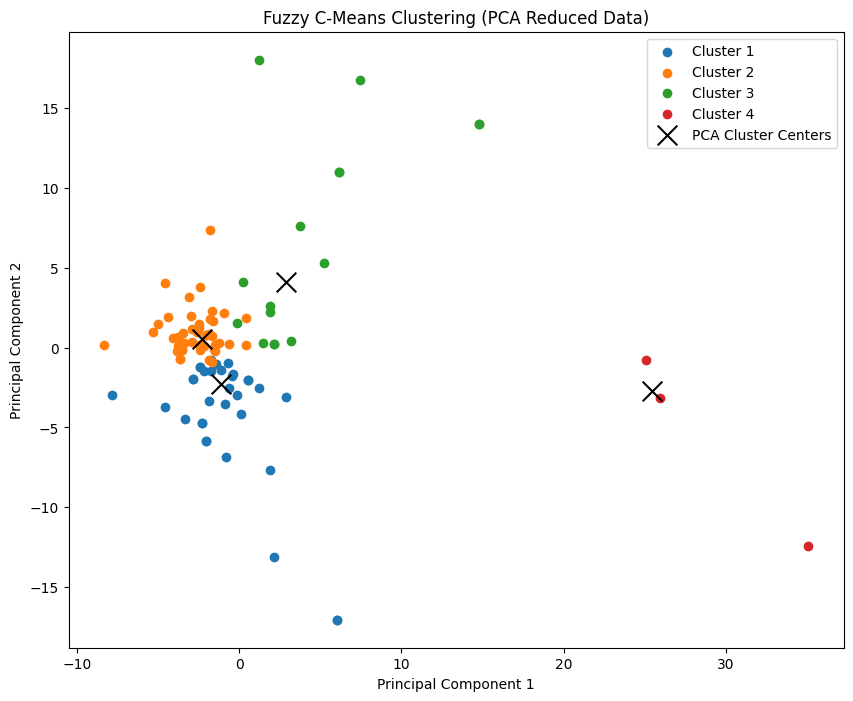

Silhouette Score: 0.32037481296783243
Davies-Bouldin Score: 1.3839204028935255
Rand Score: 0.6414629907476869
Tested fpc: 0.48544926034834185


In [49]:
# Dane
diagnosis_iterations = []

# Kolejne trenowanie modelu
for count, chunk in enumerate(chunks):
    if count == 0:
        continue
        
    print("Przetwarzamy chunk ", count)        
    # Dodajemy kolejny chunk do danych

    y_supervised = chunks_y[count]
    centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_semi_supervised_fuzzy_cmeans(chunk, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)

    print('p', p)
    print('fpc', fpc.shape, fpc)

    # Wizualizacja dla pierwszej iteracji
    cluster_labels = np.argmax(fuzzy_labels, axis=0)

    plot_pca(chunk, centroids, cluster_labels)
    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data(X_test, centroids, y_test_extended, m, g_error)
    
    diagnosis_chunk.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    
    diagnosis_iterations.append(diagnosis_iteration)


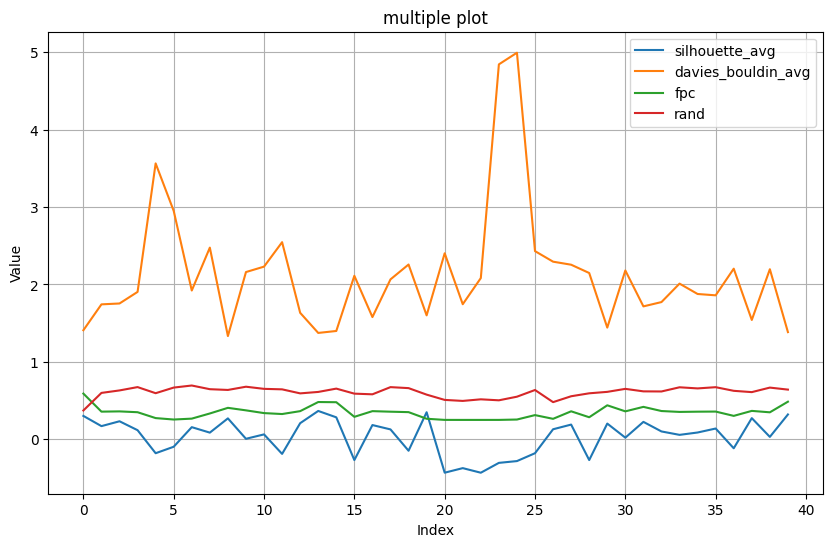

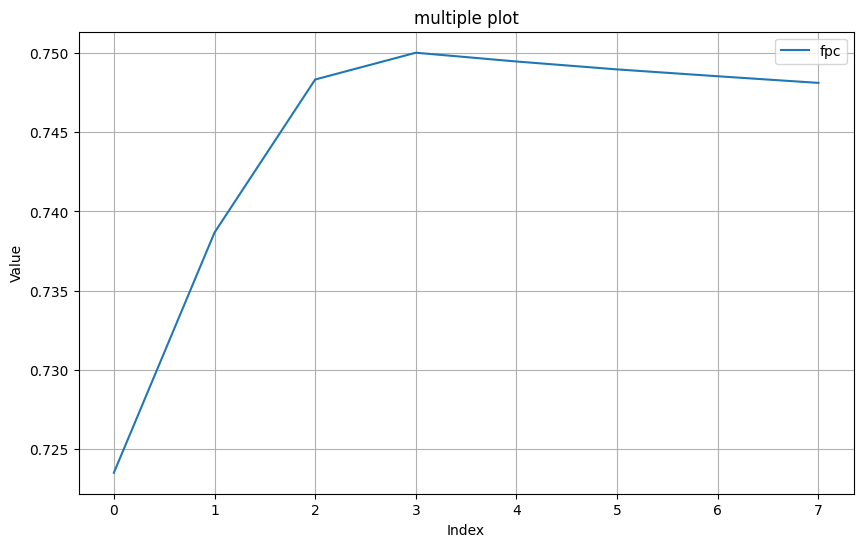

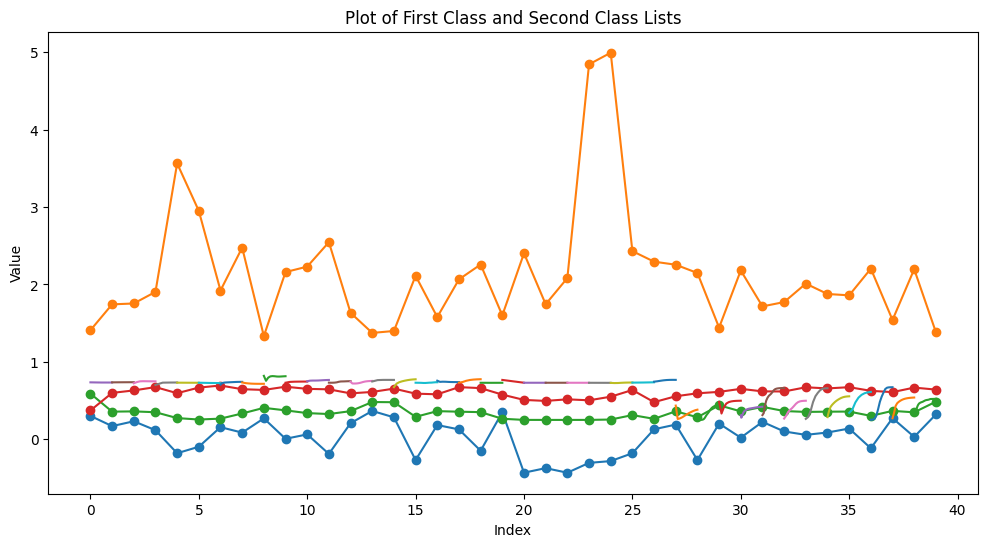

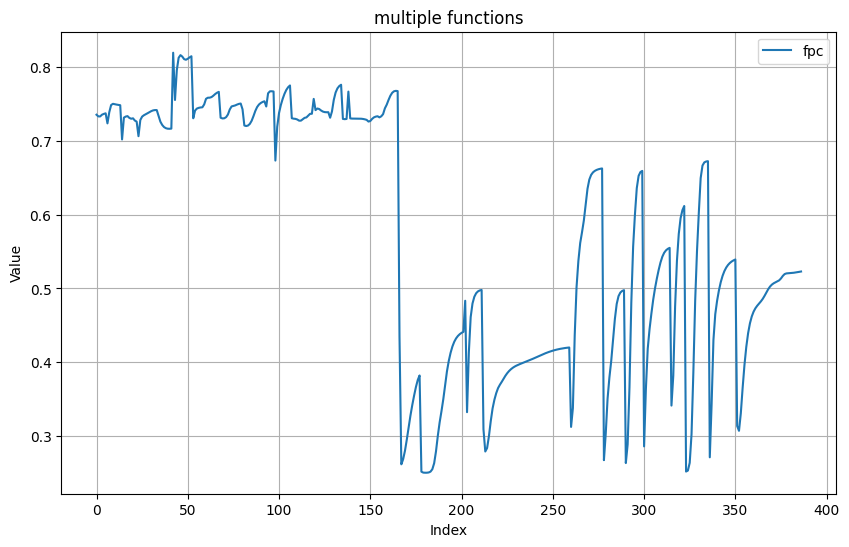

In [50]:
diagnosis_chunk.plot_lists()

diagnosis_iterations[2].plot_lists()

def prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations):
    chunk_lists = diagnosis_chunk.get_lists()
    
    lists_amount =len(diagnosis_iterations[0].get_lists())
    
    iter_lists = []
    iter_lists_concatenate = []
    
    for i in range(0,lists_amount):
        iter_lists.append([])
        iter_lists_concatenate.append([])
        
    for di in diagnosis_iterations:
        lists = di.get_lists()
        for i, list_ in enumerate(lists):
            iter_lists[i].append(list_)
            iter_lists_concatenate[i] = iter_lists_concatenate[i] + list_
    return chunk_lists, iter_lists, iter_lists_concatenate

chunk_lists, iter_lists, iter_lists_concatenate = prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations)
plot_lists_inside_lists(chunk_lists, iter_lists)

plot_multiple_functions([(iter_lists_concatenate[0],'fpc')])

In [51]:
from tqdm import tqdm
from IPython.display import clear_output
import time
import sys
import statistics

def train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y, validation_data, y_valid_extended, visualise_data=False):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    y_supervised = chunks_y[0] 
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_semi_supervised_fuzzy_cmeans(data, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=None)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data(validation_data, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)
    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        cluster_labels = np.argmax(fuzzy_labels, axis=0)
        visualize_all(data, centroids, cluster_labels)
    
    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
        y_supervised = chunks_y[count]
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_semi_supervised_fuzzy_cmeans(data, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)

        # Wizualizacja dla pierwszej iteracji
        cluster_labels = np.argmax(fuzzy_labels, axis=0)

        if(visualise_data):
            plot_pca(data, centroids, cluster_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data(validation_data, centroids, y_valid_extended, m, g_error)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations


Rozważamy obecnie chunk numer:  39
Liczba klastrów:  4


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<?, ?it/s]


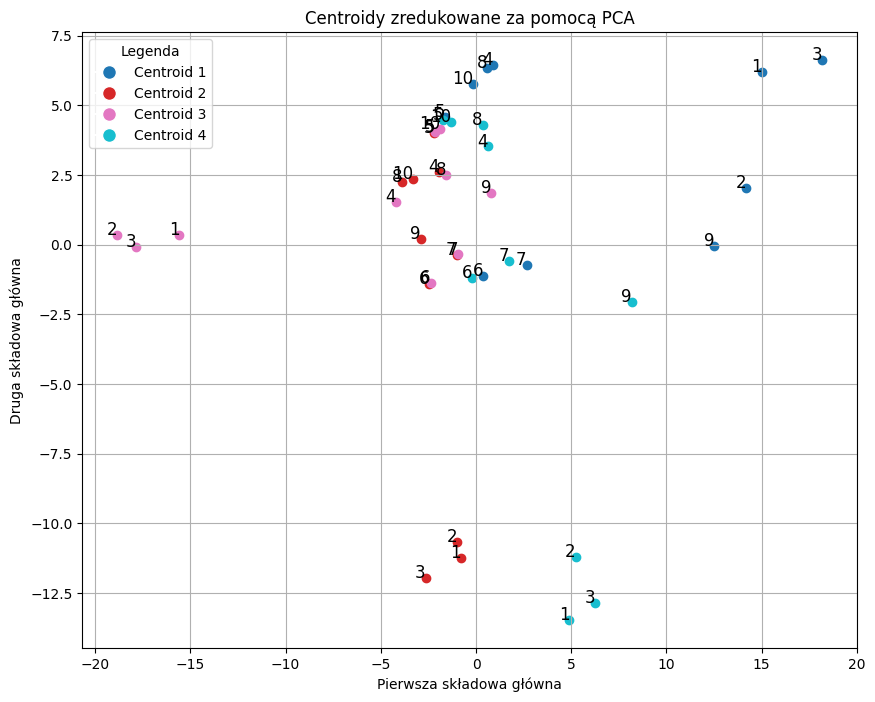

In [52]:
first_diagnosis_tools, first_diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y, X_test, y_test_extended)

first_diagnosis_tools.plot_centroid_history(10)

In [53]:
output_data_chunk = []
output_data_iter = []
for n in range(2,10):
    print('Rozważam: ', n_clusters)
    y_train_extended = label_vector_to_matrix(y_train_extended_list, n, 0.8, 0.5)
    diagnosis_tools, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n, chunks, chunks_y, X_test, y_test_extended)
    output_data_chunk.append(diagnosis_tools)
    output_data_iter.append(diagnosis_iterations)

plot_statistic = DiagnosisTools()

Rozważam:  4


IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
for n_clusters in range(2,10):
    sil, dave, fpc, rand = output_data_chunk[n_clusters-2].get_avg()
    plot_statistic.add_elements(sil, dave, fpc, rand)


plot_statistic.plot_lists()